<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Study-Design" data-toc-modified-id="Study-Design-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Study Design</a></span><ul class="toc-item"><li><span><a href="#Data" data-toc-modified-id="Data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Collect-Model-Functions" data-toc-modified-id="Collect-Model-Functions-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Collect Model Functions</a></span><ul class="toc-item"><li><span><a href="#Gaussian-Mixture" data-toc-modified-id="Gaussian-Mixture-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Gaussian Mixture</a></span></li><li><span><a href="#Garch" data-toc-modified-id="Garch-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Garch</a></span></li><li><span><a href="#Gaussian-KDE" data-toc-modified-id="Gaussian-KDE-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>Gaussian KDE</a></span></li><li><span><a href="#Historical" data-toc-modified-id="Historical-1.2.4"><span class="toc-item-num">1.2.4&nbsp;&nbsp;</span>Historical</a></span></li></ul></li></ul></li><li><span><a href="#Run-VAR-model" data-toc-modified-id="Run-VAR-model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Run VAR model</a></span></li><li><span><a href="#Evaluate-MAPE-results" data-toc-modified-id="Evaluate-MAPE-results-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Evaluate MAPE results</a></span><ul class="toc-item"><li><span><a href="#Test-model-for-other-symbols" data-toc-modified-id="Test-model-for-other-symbols-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Test model for other symbols</a></span></li></ul></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Conclusions</a></span></li><li><span><a href="#Resources-and-Citations" data-toc-modified-id="Resources-and-Citations-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Resources and Citations</a></span></li></ul></div>

In [14]:
%load_ext watermark
%watermark

%load_ext autoreload
%autoreload 2

from IPython.display import display

# import standard libs
from pathlib import Path
import sys
import time
import os
from copy import copy

# get project dir
pp = Path(Path.cwd()).parts[:-1]
pdir = Path(*pp)
data_dir = pdir/'data'
script_dir = pdir / 'scripts' 
sys.path.append(script_dir.as_posix())

# import python scientific stack
import pandas as pd
pd.options.display.float_format = '{:,.4f}'.format
import pandas_datareader as pdr
import numpy as np
import sklearn.mixture as mix
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as stats
from arch import arch_model
from numba import jit
import math

# import visual tools
from mpl_toolkits import mplot3d
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import plotnine as pn
import mizani.breaks as mzb
import mizani.formatters as mzf
import seaborn as sns
savefig_kwds=dict(dpi=300, bbox_inches='tight')

# import util libs
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
from utils import cprint

# set globals
plt.style.use('seaborn-talk')
plt.style.use('bmh')
plt.rcParams['font.family'] = 'Bitstream Vera Sans'
#plt.rcParams['font.size'] = 9.5
plt.rcParams['font.weight'] = 'medium'
plt.rcParams['figure.figsize'] = 10,7

blue, gold, green, red, purple, brown = sns.color_palette('colorblind', 6)
nanex_colors = ("#f92b20", "#fe701b", "#facd1f", "#d6fd1c", "#65fe1b",
                "#1bfe42", "#1cfdb4", "#1fb9fa", "#1e71fb", "#261cfd")
nanex_cmap = mpl.colors.ListedColormap(nanex_colors,name='nanex_cmap')
RANDOM_STATE = 777

print()
%watermark -p pandas,pandas_datareader,numpy,sklearn,statsmodels,scipy,matplotlib,seaborn,plotnine

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
2019-01-04T15:05:39-07:00

CPython 3.7.1
IPython 6.5.0

compiler   : GCC 7.3.0
system     : Linux
release    : 4.19.11-041911-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 12
interpreter: 64bit
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

pandas 0.23.4
pandas_datareader 0.7.0
numpy 1.15.4
sklearn 0.20.2
statsmodels 0.9.0
scipy 1.1.0
matplotlib 3.0.2
seaborn 0.9.0
plotnine 0.5.1


## Study Design

1. choose symbol to test (stats.guassian_kde and garch are only univariate)
2. collect model functions
3. decide on frequency and sample splits
4. iterate over train, test data 
    - collect forecasts
    - compute results for forecast period
    - collect results for forecast period
5. aggregate results
6. evaluate results and plots

### Data

In [15]:
infp = Path(data_dir/'tiingo_etf_returns_ending_2017-12-31.parq')
R = pd.read_parquet(infp)
cprint(R)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
               SPY     QQQ     TLT    GLD     EFA     EEM
date                                                     
2017-12-22 -0.0003 -0.0011  0.0014 0.0052  0.0026  0.0084
2017-12-26 -0.0012 -0.0054  0.0030 0.0068 -0.0003 -0.0009
2017-12-27  0.0005  0.0001  0.0129 0.0038  0.0019  0.0026
2017-12-28  0.0021  0.0012 -0.0009 0.0051  0.0006  0.0068
2017-12-29 -0.0038 -0.0062  0.0016 0.0065  0.0007  0.0047
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3301 entries, 2004-11-19 to 2017-12-29
Data columns (total 6 columns):
SPY    3301 non-null float64
QQQ    3301 non-null float64
TLT    3301 non-null float64
GLD    3301 non-null float64
EFA    3301 non-null float64
EEM    3301 non-null float64
dtypes: float64(6)
memory usage: 180.5 KB
None
----------------

In [16]:
test_symbol = 'SPY'
data = R[test_symbol].to_frame().loc['2005':].copy()
cprint(data)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
               SPY
date              
2017-12-22 -0.0003
2017-12-26 -0.0012
2017-12-27  0.0005
2017-12-28  0.0021
2017-12-29 -0.0038
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3272 entries, 2005-01-03 to 2017-12-29
Data columns (total 1 columns):
SPY    3272 non-null float64
dtypes: float64(1)
memory usage: 51.1 KB
None
-------------------------------------------------------------------------------



### Collect Model Functions

In [17]:
def calc_quantile_var(data, alpha=0.05):
    """
    compute var by quantile
    """
    return data.quantile(alpha)

#### Gaussian Mixture

In [18]:
# gaussian mixture model, 2 components

def gmm(data, n_components, max_iter=150, random_state=0, **kwds):
    """
    gaussian mixture model by sklearn
    """
    model = mix.GaussianMixture(n_components, max_iter=max_iter,
                                random_state=random_state, **kwds)
    model.fit(data)
    return model

def gmm_sample(data, n_components=2, max_iter=150, random_state=0,
                     n_samples=1000, risky=True, **kwds):
    """
    sample from the risky component
    """
    model = gmm(data, n_components=n_components,
                max_iter=max_iter, random_state=random_state, **kwds)
    X_s, y_s = model.sample(n_samples)
    df = pd.DataFrame(X_s, columns=data.columns).assign(component=y_s)
    if not risky: 
        ser = pd.Series(X_s.ravel())
        ser.name = 'gmm'
        return ser
    
    risky = df.groupby('component').mean().mean(1).argmin()
    ser = df.query('component==@risky').set_index('component').squeeze()
    ser.name = 'gmm_risky'
    return ser
    
def calc_gmm_var(data, n_components=2, max_iter=150, random_state=0, 
                 n_samples=1000, risky=True, **kwds):
    """
    compute quantile var for gmm risky component
    """
    gmm_samples = gmm_sample(data, 2, risky=risky)
    return calc_quantile_var(gmm_samples)

gmm_var = calc_gmm_var(data, risky=False)
gmm_var

-0.01796428573783222

#### Garch

In [19]:
# garch model 1,0,1
def garch(data, p=1, o=0, q=1, update_freq=5, **kwds):
    model = arch_model(data, 'Garch', p=p, o=o, q=q, **kwds)
    res = model.fit(update_freq=update_freq, disp=False)
    return res

def garch_forecast_sim(data, p=1, o=0, q=1, update_freq=5,
                       horizon=30, n_simulations=1000, **kwds):
    np.random.seed(0)
    garch_model = garch(data,p=p,o=o,q=q,update_freq=update_freq) 
    forecasts = garch_model.forecast(
        horizon=horizon, method='simulation',simulations=n_simulations)
    sim_ser = pd.Series(forecasts.simulations.values[-1,:,-1])
    sim_ser.name = 'garch'    
    return sim_ser

def calc_garch_var(data, p=1, o=0, q=1, update_freq=5, horizon=30, n_simulations=1000, alpha=0.05, **kwds):
    sim_ser = garch_forecast_sim(data, p=p, o=o, q=q, update_freq=update_freq,
                                 horizon=horizon, n_simulations=n_simulations//horizon, **kwds)
    var = calc_quantile_var(sim_ser, alpha=alpha)
    return var

calc_garch_var(data, n_simulations=10000)

Iteration:      5,   Func. Count:     67,   Neg. LLF: -8197.75619100534
Iteration:     10,   Func. Count:    144,   Neg. LLF: -2425.966037319834


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


-0.08278963327364014

In [20]:
calc_garch_var(data, n_simulations=10000, dist='studentT')

Iteration:      5,   Func. Count:     67,   Neg. LLF: -8197.75619100534
Iteration:     10,   Func. Count:    144,   Neg. LLF: -2425.966037319834


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


-0.07622697625287164

#### Gaussian KDE

In [21]:
# guassian kde
def gkde(data, **kwds):
    if isinstance(data, pd.DataFrame): data=data.squeeze()
    return stats.gaussian_kde(data, **kwds)

def sample_gaussian_kde(data, n_samples=1000, **kwds):
    np.random.seed(0)
    model = gkde(data, **kwds)
    samples = model.resample(n_samples).ravel()
    ser = pd.Series(samples)
    ser.name = 'gaussian_kde'
    return ser

def calc_gaussian_kde_var(data, n_samples=1000, alpha=0.05, **kwds):
    samples = sample_gaussian_kde(data, n_samples=n_samples, **kwds)
    return calc_quantile_var(samples, alpha=alpha)

calc_gaussian_kde_var(data)

-0.018508433389862633

#### Historical 

In [22]:
# historical var

def calc_historical_var(data, alpha=0.05): 
    if isinstance(data, pd.DataFrame): data=data.squeeze()
    return calc_quantile_var(data, alpha=alpha)

calc_historical_var(data)

-0.017334040349494213

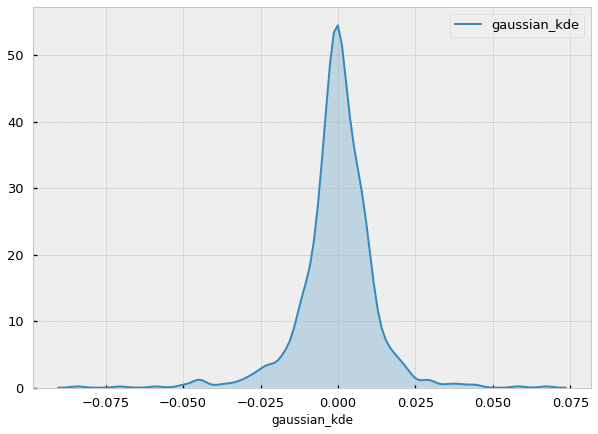

In [23]:
def plot_hist_samples(samples, ax=None):
    if not ax: ax = plt.gca()
    
    sns.distplot(samples, ax=ax, label=samples.name, 
                 hist=False, kde_kws={'shade':True})
    ax.legend()
    
plot_hist_samples(sample_gaussian_kde(data))    

Iteration:      5,   Func. Count:     67,   Neg. LLF: -8197.75619100534
Iteration:     10,   Func. Count:    144,   Neg. LLF: -2425.966037319834


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


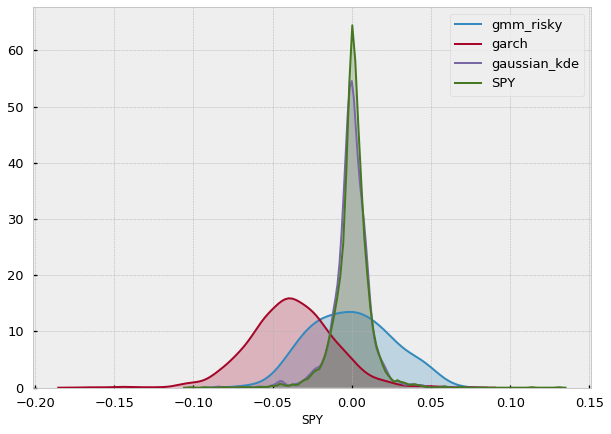

In [25]:
gmm_samples = gmm_sample(data, 2)
garch_samples = garch_forecast_sim(data)
g_kde_samples = sample_gaussian_kde(data)
hist_data = data.squeeze()

sample_series = [gmm_samples, garch_samples, g_kde_samples, hist_data]
f, ax = plt.subplots(figsize=(10,7))
for s in sample_series:
    plot_hist_samples(s, ax=ax)

## Run VAR model

In [26]:
month_index = data.resample('M').mean().index
month_index

DatetimeIndex(['2005-01-31', '2005-02-28', '2005-03-31', '2005-04-30',
               '2005-05-31', '2005-06-30', '2005-07-31', '2005-08-31',
               '2005-09-30', '2005-10-31',
               ...
               '2017-03-31', '2017-04-30', '2017-05-31', '2017-06-30',
               '2017-07-31', '2017-08-31', '2017-09-30', '2017-10-31',
               '2017-11-30', '2017-12-31'],
              dtype='datetime64[ns]', name='date', length=156, freq='M')

In [28]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

np.random.seed(0)

lookback = 252

# stash model predictions
keys = ['gmm', 'gmm_risky', 'garch_normal', 'garch_t', 'gkde', 'historical']
predictions = dict.fromkeys(keys)

for k in predictions.keys(): predictions[k] = []

# stash actual minimum returns for next period
min_month_returns = []

### begin model code ###

for i, month_end in enumerate(month_index):
    if not data.loc[:month_end].shape[0] > lookback: continue
    
    train = data.loc[:month_end].iloc[-lookback:]
    test = data.loc[month_end+pd.Timedelta(days=1):month_index[i+1]]
    
    # calc vars
    gmm_var = calc_gmm_var(train, risky=False)
    gmm_risky_var = calc_gmm_var(train, risky=True)
    garch_norm_var = calc_garch_var(train, n_simulations=10000, dist='Normal')
    garch_t_var = calc_garch_var(train, n_simulations=10000, dist='StudentT')
    gkde_var = calc_gaussian_kde_var(train)
    hist_var = calc_historical_var(train)    
    
    train_vars = [gmm_var, gmm_risky_var,
                  garch_norm_var, garch_t_var,
                  gkde_var, hist_var]
    for k, var in zip(predictions.keys(), train_vars): predictions[k].append(var)
        
    min_month_returns.append(test.squeeze().min())
    

/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     52,   Neg. LLF: -914.1458613565688
Iteration:      5,   Func. Count:     52,   Neg. LLF: -914.1458613565688


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     59,   Neg. LLF: -922.0173358859662
Iteration:      5,   Func. Count:     59,   Neg. LLF: -922.0173358859662
Iteration:      5,   Func. Count:     51,   Neg. LLF: -907.682660907031
Iteration:      5,   Func. Count:     51,   Neg. LLF: -907.682660907031


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     55,   Neg. LLF: -899.3005489074808
Iteration:      5,   Func. Count:     55,   Neg. LLF: -899.3005489074808


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     64,   Neg. LLF: -936.9202516164103
Iteration:      5,   Func. Count:     64,   Neg. LLF: -936.9202516164103


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     55,   Neg. LLF: -913.4880557705164
Iteration:      5,   Func. Count:     55,   Neg. LLF: -913.4880557705164


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     59,   Neg. LLF: -833.1182054859316
Iteration:     10,   Func. Count:    133,   Neg. LLF: -833.1198053195521
Iteration:      5,   Func. Count:     59,   Neg. LLF: -833.1182054859316
Iteration:     10,   Func. Count:    133,   Neg. LLF: -833.1198053195521
Iteration:      5,   Func. Count:     55,   Neg. LLF: -814.6396201650816
Iteration:     10,   Func. Count:    104,   Neg. LLF: -815.4197550173155
Iteration:     15,   Func. Count:    140,   Neg. LLF: -815.9207961229683


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     55,   Neg. LLF: -814.6396201650816
Iteration:     10,   Func. Count:    104,   Neg. LLF: -815.4197550173155
Iteration:     15,   Func. Count:    140,   Neg. LLF: -815.9207961229683
Iteration:      5,   Func. Count:     57,   Neg. LLF: -793.3707660653877
Iteration:     10,   Func. Count:    118,   Neg. LLF: -793.3744432450856
Iteration:      5,   Func. Count:     57,   Neg. LLF: -793.3707660653877
Iteration:     10,   Func. Count:    118,   Neg. LLF: -793.3744432450856


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     44,   Neg. LLF: -758.2367885314447
Iteration:      5,   Func. Count:     44,   Neg. LLF: -758.2367885314447
Iteration:      5,   Func. Count:     51,   Neg. LLF: -750.8978127813756
Iteration:     10,   Func. Count:     89,   Neg. LLF: -750.9818174265409
Iteration:      5,   Func. Count:     51,   Neg. LLF: -750.8978127813756
Iteration:     10,   Func. Count:     89,   Neg. LLF: -750.9818174265409


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     48,   Neg. LLF: -749.7379237573191
Iteration:     10,   Func. Count:     93,   Neg. LLF: -749.8232139386756
Iteration:      5,   Func. Count:     48,   Neg. LLF: -749.7379237573191
Iteration:     10,   Func. Count:     93,   Neg. LLF: -749.8232139386756
Iteration:      5,   Func. Count:     56,   Neg. LLF: -676.1545003678439
Iteration:      5,   Func. Count:     56,   Neg. LLF: -676.1545003678439


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     54,   Neg. LLF: -627.9949374612164
Iteration:     10,   Func. Count:     88,   Neg. LLF: -629.6030825749457
Iteration:      5,   Func. Count:     54,   Neg. LLF: -627.9949374612164
Iteration:     10,   Func. Count:     88,   Neg. LLF: -629.6030825749457


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     53,   Neg. LLF: -790.2437002479801
Iteration:     10,   Func. Count:     95,   Neg. LLF: -790.7478068322041
Iteration:      5,   Func. Count:     53,   Neg. LLF: -790.2437002479801
Iteration:     10,   Func. Count:     95,   Neg. LLF: -790.7478068322041
Iteration:      5,   Func. Count:     57,   Neg. LLF: -778.9314561682039
Iteration:      5,   Func. Count:     57,   Neg. LLF: -778.9314561682039


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     55,   Neg. LLF: -804.5536359656487
Iteration:      5,   Func. Count:     55,   Neg. LLF: -804.5536359656487
Iteration:      5,   Func. Count:     63,   Neg. LLF: -811.8340461730465
Iteration:      5,   Func. Count:     63,   Neg. LLF: -811.8340461730465


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     54,   Neg. LLF: -840.8495943156241
Iteration:     10,   Func. Count:    115,   Neg. LLF: -840.8505242046907
Iteration:      5,   Func. Count:     54,   Neg. LLF: -840.8495943156241
Iteration:     10,   Func. Count:    115,   Neg. LLF: -840.8505242046907


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     55,   Neg. LLF: -767.0054763718581
Iteration:     10,   Func. Count:    118,   Neg. LLF: -767.006661590753
Iteration:      5,   Func. Count:     55,   Neg. LLF: -767.0054763718581
Iteration:     10,   Func. Count:    118,   Neg. LLF: -767.006661590753
Iteration:      5,   Func. Count:     62,   Neg. LLF: -755.472454278616
Iteration:      5,   Func. Count:     62,   Neg. LLF: -755.472454278616


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     58,   Neg. LLF: -830.9413023485208
Iteration:      5,   Func. Count:     58,   Neg. LLF: -830.9413023485208


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     55,   Neg. LLF: -861.8987157985571
Iteration:      5,   Func. Count:     55,   Neg. LLF: -861.8987157985571


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     55,   Neg. LLF: -887.187628687253
Iteration:      5,   Func. Count:     55,   Neg. LLF: -887.187628687253
Iteration:      5,   Func. Count:     50,   Neg. LLF: -881.9928617631385
Iteration:      5,   Func. Count:     50,   Neg. LLF: -881.9928617631385


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     51,   Neg. LLF: -887.8007077393802
Iteration:     10,   Func. Count:    100,   Neg. LLF: -887.8614579638557
Iteration:      5,   Func. Count:     51,   Neg. LLF: -887.8007077393802
Iteration:     10,   Func. Count:    100,   Neg. LLF: -887.8614579638557


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     54,   Neg. LLF: -901.665021904638
Iteration:      5,   Func. Count:     54,   Neg. LLF: -901.665021904638


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     55,   Neg. LLF: -892.6705770467918
Iteration:      5,   Func. Count:     55,   Neg. LLF: -892.6705770467918
Iteration:      5,   Func. Count:     53,   Neg. LLF: -889.9512405746682
Iteration:      5,   Func. Count:     53,   Neg. LLF: -889.9512405746682


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     55,   Neg. LLF: -896.7984148524836
Iteration:      5,   Func. Count:     55,   Neg. LLF: -896.7984148524836


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     44,   Neg. LLF: -913.1477905709668
Iteration:     10,   Func. Count:     80,   Neg. LLF: -913.248294888178
Iteration:      5,   Func. Count:     44,   Neg. LLF: -913.1477905709668
Iteration:     10,   Func. Count:     80,   Neg. LLF: -913.248294888178


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     55,   Neg. LLF: -908.3813038862212
Iteration:      5,   Func. Count:     55,   Neg. LLF: -908.3813038862212
Iteration:      5,   Func. Count:     58,   Neg. LLF: -915.4626298700796
Iteration:      5,   Func. Count:     58,   Neg. LLF: -915.4626298700796


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     44,   Neg. LLF: -900.5025650035719
Iteration:      5,   Func. Count:     44,   Neg. LLF: -900.5025650035719
Iteration:      5,   Func. Count:     55,   Neg. LLF: -896.9079768816874
Iteration:      5,   Func. Count:     55,   Neg. LLF: -896.9079768816874
Iteration:      5,   Func. Count:     55,   Neg. LLF: -899.6649557570923
Iteration:      5,   Func. Count:     55,   Neg. LLF: -899.6649557570923
Iteration:      5,   Func. Count:     54,   Neg. LLF: -860.6361331978118
Iteration:     10,   Func. Count:     98,   Neg. LLF: -861.060819097447
Iteration:     15,   Func. Count:    130,   Neg. LLF: -861.3154751756184
Iteration:      5,   Func. Count:     54,   Neg. LLF: -860.6361331978118
Iteration:     10,   Func. Count:     98,   Neg. LLF: -861.060819097447
Iteration:     15,   Func. Count:    130,   Neg. LLF: -861.3154751756184


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     51,   Neg. LLF: -836.7047813939882
Iteration:     10,   Func. Count:     88,   Neg. LLF: -837.2552688364929
Iteration:      5,   Func. Count:     51,   Neg. LLF: -836.7047813939882
Iteration:     10,   Func. Count:     88,   Neg. LLF: -837.2552688364929
Iteration:      5,   Func. Count:     54,   Neg. LLF: -832.0911351396369
Iteration:      5,   Func. Count:     54,   Neg. LLF: -832.0911351396369
Iteration:      5,   Func. Count:     44,   Neg. LLF: -823.0158427169991
Iteration:      5,   Func. Count:     44,   Neg. LLF: -823.0158427169991
Iteration:      5,   Func. Count:     56,   Neg. LLF: -811.14423615947
Iteration:      5,   Func. Count:     56,   Neg. LLF: -811.14423615947


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     54,   Neg. LLF: -812.5705707796897
Iteration:     10,   Func. Count:    102,   Neg. LLF: -812.8618713209967
Iteration:     15,   Func. Count:    136,   Neg. LLF: -812.9931799942157
Iteration:      5,   Func. Count:     54,   Neg. LLF: -812.5705707796897
Iteration:     10,   Func. Count:    102,   Neg. LLF: -812.8618713209967
Iteration:     15,   Func. Count:    136,   Neg. LLF: -812.9931799942157
Iteration:      5,   Func. Count:     50,   Neg. LLF: -805.8690637031837
Iteration:      5,   Func. Count:     50,   Neg. LLF: -805.8690637031837
Iteration:      5,   Func. Count:     52,   Neg. LLF: -809.679026790252
Iteration:      5,   Func. Count:     52,   Neg. LLF: -809.679026790252


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     55,   Neg. LLF: -845.1940130112805
Iteration:      5,   Func. Count:     55,   Neg. LLF: -845.1940130112805


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     55,   Neg. LLF: -859.9070218073718
Iteration:      5,   Func. Count:     55,   Neg. LLF: -859.9070218073718
Iteration:      5,   Func. Count:     46,   Neg. LLF: -877.5884636173316
Iteration:      5,   Func. Count:     46,   Neg. LLF: -877.5884636173316


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     59,   Neg. LLF: -971.1521388459545
Iteration:      5,   Func. Count:     59,   Neg. LLF: -971.1521388459545


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

IndexError: index 156 is out of bounds for axis 0 with size 156

## Evaluate MAPE results

In this experiment we will use [Mean Absolute Percentage Error (MAPE)](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error) to evaluate the VAR prediction results. This is a relatively easy to interpret measure of the prediction error.

In [29]:
# https://stackoverflow.com/questions/42250958/how-to-optimize-mape-code-in-python/42251083#42251083

def mape_vectorized_v2(actual, predict): 
    mask = actual != 0
    return (np.fabs(actual - predict)/actual)[mask].mean() 

model_errors = dict.fromkeys(keys)
for k in model_errors.keys(): model_errors[k] = []
    
actual = np.asarray(min_month_returns)
for k, predict in predictions.items():
    model_errors[k].append(mape_vectorized_v2(actual, predict))

error_df = (pd.DataFrame.
            from_dict(model_errors)
            .T
            .squeeze()
            .sort_values(ascending=False)*100.)
error_df

garch_normal   -50.6935
garch_t        -50.8588
historical     -59.4449
gmm            -59.5820
gkde           -62.9675
gmm_risky      -91.1430
Name: 0, dtype: float64

### Test model for other symbols

In [30]:
def run_model(return_dataframe, symbol, keys, lookback=252):
    
    # get data
    data = return_dataframe[symbol].to_frame().loc['2005':].copy()    
    
    np.random.seed(0)

    # stash model predictions
    predictions = dict.fromkeys(keys)
    for k in predictions.keys(): predictions[k] = []

    # stash actual minimum returns for next period
    min_month_returns = []

    ### begin model code ###

    for i, month_end in enumerate(month_index):
        try:
            if not data.loc[:month_end].shape[0] > lookback: continue

            train = data.loc[:month_end].iloc[-lookback:]
            test = data.loc[month_end+pd.Timedelta(days=1):month_index[i+1]]

            # calc vars
            gmm_var = calc_gmm_var(train, risky=False)
            gmm_risky_var = calc_gmm_var(train, risky=True)
            garch_norm_var = calc_garch_var(train, n_simulations=10000, dist='Normal')
            garch_t_var = calc_garch_var(train, n_simulations=10000, dist='StudentT')
            gkde_var = calc_gaussian_kde_var(train)
            hist_var = calc_historical_var(train)    

            train_vars = [gmm_var, gmm_risky_var,
                          garch_norm_var, garch_t_var,
                          gkde_var, hist_var]
            for k, var in zip(predictions.keys(), train_vars): predictions[k].append(var)

            min_month_returns.append(test.squeeze().min())
        except Exception as e:
            print(e)
        
    return min_month_returns, predictions

def calc_model_mape(actual, predictions, symbol, keys):
    """
    
    """
    # https://stackoverflow.com/questions/42250958/how-to-optimize-mape-code-in-python/42251083#42251083

    def mape_vectorized_v2(actual, predict): 
        mask = actual != 0
        return (np.fabs(actual - predict)/actual)[mask].mean() 

    model_errors = dict.fromkeys(keys)
    for k in model_errors.keys(): model_errors[k] = []

    actual = np.asarray(min_month_returns)
    for k, predict in predictions.items():
        model_errors[k].append(mape_vectorized_v2(actual, predict))

    error_df = (pd.DataFrame.
                from_dict(model_errors)
                .T
                .squeeze()
                .sort_values(ascending=False)*100.)
    error_df.name = symbol
    return error_df    

In [31]:
errors = []
for symbol in R.columns:
    try:
        actual, predictions = run_model(R, symbol, keys)
        tmp_errors = calc_model_mape(actual, predictions, symbol, keys)
        errors.append(tmp_errors)
    except Exception as e:
        print(e)

/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     52,   Neg. LLF: -914.1458613565688
Iteration:      5,   Func. Count:     52,   Neg. LLF: -914.1458613565688


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     59,   Neg. LLF: -922.0173358859662
Iteration:      5,   Func. Count:     59,   Neg. LLF: -922.0173358859662
Iteration:      5,   Func. Count:     51,   Neg. LLF: -907.682660907031
Iteration:      5,   Func. Count:     51,   Neg. LLF: -907.682660907031


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     55,   Neg. LLF: -899.3005489074808
Iteration:      5,   Func. Count:     55,   Neg. LLF: -899.3005489074808


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     64,   Neg. LLF: -936.9202516164103
Iteration:      5,   Func. Count:     64,   Neg. LLF: -936.9202516164103


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     55,   Neg. LLF: -913.4880557705164
Iteration:      5,   Func. Count:     55,   Neg. LLF: -913.4880557705164


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     59,   Neg. LLF: -833.1182054859316
Iteration:     10,   Func. Count:    133,   Neg. LLF: -833.1198053195521
Iteration:      5,   Func. Count:     59,   Neg. LLF: -833.1182054859316
Iteration:     10,   Func. Count:    133,   Neg. LLF: -833.1198053195521
Iteration:      5,   Func. Count:     55,   Neg. LLF: -814.6396201650816
Iteration:     10,   Func. Count:    104,   Neg. LLF: -815.4197550173155
Iteration:     15,   Func. Count:    140,   Neg. LLF: -815.9207961229683


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     55,   Neg. LLF: -814.6396201650816
Iteration:     10,   Func. Count:    104,   Neg. LLF: -815.4197550173155
Iteration:     15,   Func. Count:    140,   Neg. LLF: -815.9207961229683
Iteration:      5,   Func. Count:     57,   Neg. LLF: -793.3707660653877
Iteration:     10,   Func. Count:    118,   Neg. LLF: -793.3744432450856
Iteration:      5,   Func. Count:     57,   Neg. LLF: -793.3707660653877
Iteration:     10,   Func. Count:    118,   Neg. LLF: -793.3744432450856


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     44,   Neg. LLF: -758.2367885314447
Iteration:      5,   Func. Count:     44,   Neg. LLF: -758.2367885314447
Iteration:      5,   Func. Count:     51,   Neg. LLF: -750.8978127813756
Iteration:     10,   Func. Count:     89,   Neg. LLF: -750.9818174265409
Iteration:      5,   Func. Count:     51,   Neg. LLF: -750.8978127813756
Iteration:     10,   Func. Count:     89,   Neg. LLF: -750.9818174265409


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     48,   Neg. LLF: -749.7379237573191
Iteration:     10,   Func. Count:     93,   Neg. LLF: -749.8232139386756
Iteration:      5,   Func. Count:     48,   Neg. LLF: -749.7379237573191
Iteration:     10,   Func. Count:     93,   Neg. LLF: -749.8232139386756
Iteration:      5,   Func. Count:     56,   Neg. LLF: -676.1545003678439
Iteration:      5,   Func. Count:     56,   Neg. LLF: -676.1545003678439


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     54,   Neg. LLF: -627.9949374612164
Iteration:     10,   Func. Count:     88,   Neg. LLF: -629.6030825749457
Iteration:      5,   Func. Count:     54,   Neg. LLF: -627.9949374612164
Iteration:     10,   Func. Count:     88,   Neg. LLF: -629.6030825749457


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     53,   Neg. LLF: -790.2437002479801
Iteration:     10,   Func. Count:     95,   Neg. LLF: -790.7478068322041
Iteration:      5,   Func. Count:     53,   Neg. LLF: -790.2437002479801
Iteration:     10,   Func. Count:     95,   Neg. LLF: -790.7478068322041
Iteration:      5,   Func. Count:     57,   Neg. LLF: -778.9314561682039
Iteration:      5,   Func. Count:     57,   Neg. LLF: -778.9314561682039


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     55,   Neg. LLF: -804.5536359656487
Iteration:      5,   Func. Count:     55,   Neg. LLF: -804.5536359656487
Iteration:      5,   Func. Count:     63,   Neg. LLF: -811.8340461730465
Iteration:      5,   Func. Count:     63,   Neg. LLF: -811.8340461730465


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     54,   Neg. LLF: -840.8495943156241
Iteration:     10,   Func. Count:    115,   Neg. LLF: -840.8505242046907
Iteration:      5,   Func. Count:     54,   Neg. LLF: -840.8495943156241
Iteration:     10,   Func. Count:    115,   Neg. LLF: -840.8505242046907


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     55,   Neg. LLF: -767.0054763718581
Iteration:     10,   Func. Count:    118,   Neg. LLF: -767.006661590753
Iteration:      5,   Func. Count:     55,   Neg. LLF: -767.0054763718581
Iteration:     10,   Func. Count:    118,   Neg. LLF: -767.006661590753
Iteration:      5,   Func. Count:     62,   Neg. LLF: -755.472454278616
Iteration:      5,   Func. Count:     62,   Neg. LLF: -755.472454278616


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     58,   Neg. LLF: -830.9413023485208
Iteration:      5,   Func. Count:     58,   Neg. LLF: -830.9413023485208


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     55,   Neg. LLF: -861.8987157985571
Iteration:      5,   Func. Count:     55,   Neg. LLF: -861.8987157985571


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     55,   Neg. LLF: -887.187628687253
Iteration:      5,   Func. Count:     55,   Neg. LLF: -887.187628687253
Iteration:      5,   Func. Count:     50,   Neg. LLF: -881.9928617631385
Iteration:      5,   Func. Count:     50,   Neg. LLF: -881.9928617631385


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     51,   Neg. LLF: -887.8007077393802
Iteration:     10,   Func. Count:    100,   Neg. LLF: -887.8614579638557
Iteration:      5,   Func. Count:     51,   Neg. LLF: -887.8007077393802
Iteration:     10,   Func. Count:    100,   Neg. LLF: -887.8614579638557


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     54,   Neg. LLF: -901.665021904638
Iteration:      5,   Func. Count:     54,   Neg. LLF: -901.665021904638


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     55,   Neg. LLF: -892.6705770467918
Iteration:      5,   Func. Count:     55,   Neg. LLF: -892.6705770467918
Iteration:      5,   Func. Count:     53,   Neg. LLF: -889.9512405746682
Iteration:      5,   Func. Count:     53,   Neg. LLF: -889.9512405746682


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     55,   Neg. LLF: -896.7984148524836
Iteration:      5,   Func. Count:     55,   Neg. LLF: -896.7984148524836


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     44,   Neg. LLF: -913.1477905709668
Iteration:     10,   Func. Count:     80,   Neg. LLF: -913.248294888178
Iteration:      5,   Func. Count:     44,   Neg. LLF: -913.1477905709668
Iteration:     10,   Func. Count:     80,   Neg. LLF: -913.248294888178


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     55,   Neg. LLF: -908.3813038862212
Iteration:      5,   Func. Count:     55,   Neg. LLF: -908.3813038862212
Iteration:      5,   Func. Count:     58,   Neg. LLF: -915.4626298700796
Iteration:      5,   Func. Count:     58,   Neg. LLF: -915.4626298700796


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     44,   Neg. LLF: -900.5025650035719
Iteration:      5,   Func. Count:     44,   Neg. LLF: -900.5025650035719
Iteration:      5,   Func. Count:     55,   Neg. LLF: -896.9079768816874
Iteration:      5,   Func. Count:     55,   Neg. LLF: -896.9079768816874
Iteration:      5,   Func. Count:     55,   Neg. LLF: -899.6649557570923
Iteration:      5,   Func. Count:     55,   Neg. LLF: -899.6649557570923
Iteration:      5,   Func. Count:     54,   Neg. LLF: -860.6361331978118
Iteration:     10,   Func. Count:     98,   Neg. LLF: -861.060819097447
Iteration:     15,   Func. Count:    130,   Neg. LLF: -861.3154751756184
Iteration:      5,   Func. Count:     54,   Neg. LLF: -860.6361331978118
Iteration:     10,   Func. Count:     98,   Neg. LLF: -861.060819097447
Iteration:     15,   Func. Count:    130,   Neg. LLF: -861.3154751756184


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     51,   Neg. LLF: -836.7047813939882
Iteration:     10,   Func. Count:     88,   Neg. LLF: -837.2552688364929
Iteration:      5,   Func. Count:     51,   Neg. LLF: -836.7047813939882
Iteration:     10,   Func. Count:     88,   Neg. LLF: -837.2552688364929
Iteration:      5,   Func. Count:     54,   Neg. LLF: -832.0911351396369
Iteration:      5,   Func. Count:     54,   Neg. LLF: -832.0911351396369
Iteration:      5,   Func. Count:     44,   Neg. LLF: -823.0158427169991
Iteration:      5,   Func. Count:     44,   Neg. LLF: -823.0158427169991
Iteration:      5,   Func. Count:     56,   Neg. LLF: -811.14423615947
Iteration:      5,   Func. Count:     56,   Neg. LLF: -811.14423615947


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     54,   Neg. LLF: -812.5705707796897
Iteration:     10,   Func. Count:    102,   Neg. LLF: -812.8618713209967
Iteration:     15,   Func. Count:    136,   Neg. LLF: -812.9931799942157
Iteration:      5,   Func. Count:     54,   Neg. LLF: -812.5705707796897
Iteration:     10,   Func. Count:    102,   Neg. LLF: -812.8618713209967
Iteration:     15,   Func. Count:    136,   Neg. LLF: -812.9931799942157
Iteration:      5,   Func. Count:     50,   Neg. LLF: -805.8690637031837
Iteration:      5,   Func. Count:     50,   Neg. LLF: -805.8690637031837
Iteration:      5,   Func. Count:     52,   Neg. LLF: -809.679026790252
Iteration:      5,   Func. Count:     52,   Neg. LLF: -809.679026790252


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     55,   Neg. LLF: -845.1940130112805
Iteration:      5,   Func. Count:     55,   Neg. LLF: -845.1940130112805


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     55,   Neg. LLF: -859.9070218073718
Iteration:      5,   Func. Count:     55,   Neg. LLF: -859.9070218073718
Iteration:      5,   Func. Count:     46,   Neg. LLF: -877.5884636173316
Iteration:      5,   Func. Count:     46,   Neg. LLF: -877.5884636173316


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     59,   Neg. LLF: -971.1521388459545
Iteration:      5,   Func. Count:     59,   Neg. LLF: -971.1521388459545


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

index 156 is out of bounds for axis 0 with size 156
Iteration:      5,   Func. Count:     53,   Neg. LLF: -846.3110242996702
Iteration:     10,   Func. Count:    107,   Neg. LLF: -846.3121110562624
Iteration:     15,   Func. Count:    148,   Neg. LLF: -846.4450929046536
Iteration:      5,   Func. Count:     53,   Neg. LLF: -846.3110242996702


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:     10,   Func. Count:    107,   Neg. LLF: -846.3121110562624
Iteration:     15,   Func. Count:    148,   Neg. LLF: -846.4450929046536
Iteration:      5,   Func. Count:     64,   Neg. LLF: -860.65482775325


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     64,   Neg. LLF: -860.65482775325


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     60,   Neg. LLF: -813.6250560302094
Iteration:      5,   Func. Count:     60,   Neg. LLF: -813.6250560302094
Iteration:      5,   Func. Count:     53,   Neg. LLF: -807.2181628406934
Iteration:      5,   Func. Count:     53,   Neg. LLF: -807.2181628406934


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     57,   Neg. LLF: -807.3681198934289
Iteration:      5,   Func. Count:     57,   Neg. LLF: -807.3681198934289


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     59,   Neg. LLF: -805.9158445526549
Iteration:     10,   Func. Count:    132,   Neg. LLF: -805.9184085442935
Iteration:      5,   Func. Count:     59,   Neg. LLF: -805.9158445526549
Iteration:     10,   Func. Count:    132,   Neg. LLF: -805.9184085442935


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     41,   Neg. LLF: -833.9484544336617
Iteration:      5,   Func. Count:     41,   Neg. LLF: -833.9484544336617
Iteration:      5,   Func. Count:     55,   Neg. LLF: -819.0140543950235
Iteration:      5,   Func. Count:     55,   Neg. LLF: -819.0140543950235


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     56,   Neg. LLF: -790.0142511972838
Iteration:     10,   Func. Count:    123,   Neg. LLF: -790.3930553323748
Iteration:      5,   Func. Count:     56,   Neg. LLF: -790.0142511972838
Iteration:     10,   Func. Count:    123,   Neg. LLF: -790.3930553323748


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     53,   Neg. LLF: -762.6671589156217
Iteration:      5,   Func. Count:     53,   Neg. LLF: -762.6671589156217


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     53,   Neg. LLF: -730.795578680172
Iteration:     10,   Func. Count:    115,   Neg. LLF: -730.7967319840313
Iteration:      5,   Func. Count:     53,   Neg. LLF: -730.795578680172
Iteration:     10,   Func. Count:    115,   Neg. LLF: -730.7967319840313
Iteration:      5,   Func. Count:     54,   Neg. LLF: -721.4598134644614
Iteration:     10,   Func. Count:    121,   Neg. LLF: -721.4676452973449
Iteration:      5,   Func. Count:     54,   Neg. LLF: -721.4598134644614
Iteration:     10,   Func. Count:    121,   Neg. LLF: -721.4676452973449


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     63,   Neg. LLF: -706.0945905212998
Iteration:      5,   Func. Count:     63,   Neg. LLF: -706.0945905212998


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     46,   Neg. LLF: -698.3247025195901
Iteration:     10,   Func. Count:     82,   Neg. LLF: -698.4686793321075
Iteration:     15,   Func. Count:    117,   Neg. LLF: -698.5580726323764
Iteration:     20,   Func. Count:    153,   Neg. LLF: -698.634308564627
Iteration:     25,   Func. Count:    183,   Neg. LLF: -698.7716883811739
Iteration:      5,   Func. Count:     46,   Neg. LLF: -698.3247025195901
Iteration:     10,   Func. Count:     82,   Neg. LLF: -698.4686793321075
Iteration:     15,   Func. Count:    117,   Neg. LLF: -698.5580726323764
Iteration:     20,   Func. Count:    153,   Neg. LLF: -698.634308564627
Iteration:     25,   Func. Count:    183,   Neg. LLF: -698.7716883811739
Iteration:      5,   Func. Count:     51,   Neg. LLF: -671.7838076024284
Iteration:     10,   Func. Count:     96,   Neg. LLF: -672.1653765204749
Iteration:     15,   Func. Count:    129,   Neg. LLF: -672.3754690632007
Iteration:      5,   Func. Count:     51,   Neg. LLF:

/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     45,   Neg. LLF: -593.5883669554499
Iteration:     10,   Func. Count:     80,   Neg. LLF: -593.761624017651
Iteration:      5,   Func. Count:     45,   Neg. LLF: -593.5883669554499
Iteration:     10,   Func. Count:     80,   Neg. LLF: -593.761624017651
Iteration:      5,   Func. Count:     49,   Neg. LLF: -587.4324377540872
Iteration:      5,   Func. Count:     49,   Neg. LLF: -587.4324377540872


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     43,   Neg. LLF: -583.7312511036231
Iteration:      5,   Func. Count:     43,   Neg. LLF: -583.7312511036231


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     56,   Neg. LLF: -720.4490082529949
Iteration:      5,   Func. Count:     56,   Neg. LLF: -720.4490082529949


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     45,   Neg. LLF: -781.5283641642602
Iteration:     10,   Func. Count:     81,   Neg. LLF: -782.0451452634553
Iteration:      5,   Func. Count:     45,   Neg. LLF: -781.5283641642602
Iteration:     10,   Func. Count:     81,   Neg. LLF: -782.0451452634553
Iteration:      5,   Func. Count:     56,   Neg. LLF: -761.7310310736617
Iteration:     10,   Func. Count:    115,   Neg. LLF: -761.7422340736014
Iteration:     15,   Func. Count:    163,   Neg. LLF: -762.130941216574
Iteration:      5,   Func. Count:     56,   Neg. LLF: -761.7310310736617
Iteration:     10,   Func. Count:    115,   Neg. LLF: -761.7422340736014
Iteration:     15,   Func. Count:    163,   Neg. LLF: -762.130941216574
Iteration:      5,   Func. Count:     53,   Neg. LLF: -768.2242944152504
Iteration:      5,   Func. Count:     53,   Neg. LLF: -768.2242944152504


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     58,   Neg. LLF: -772.3414759927725
Iteration:     10,   Func. Count:    117,   Neg. LLF: -772.5241685771603
Iteration:     15,   Func. Count:    156,   Neg. LLF: -772.8624786711703
Iteration:      5,   Func. Count:     58,   Neg. LLF: -772.3414759927725
Iteration:     10,   Func. Count:    117,   Neg. LLF: -772.5241685771603
Iteration:     15,   Func. Count:    156,   Neg. LLF: -772.8624786711703
Iteration:      5,   Func. Count:     62,   Neg. LLF: -785.4941241223944
Iteration:      5,   Func. Count:     62,   Neg. LLF: -785.4941241223944


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     54,   Neg. LLF: -782.4433345791103
Iteration:      5,   Func. Count:     54,   Neg. LLF: -782.4433345791103
Iteration:      5,   Func. Count:     55,   Neg. LLF: -768.8991010522935
Iteration:      5,   Func. Count:     55,   Neg. LLF: -768.8991010522935


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     50,   Neg. LLF: -755.0270754936537
Iteration:      5,   Func. Count:     50,   Neg. LLF: -755.0270754936537
Iteration:      5,   Func. Count:     53,   Neg. LLF: -746.7862394801019
Iteration:     10,   Func. Count:     87,   Neg. LLF: -747.4070546606624
Iteration:      5,   Func. Count:     53,   Neg. LLF: -746.7862394801019
Iteration:     10,   Func. Count:     87,   Neg. LLF: -747.4070546606624
Iteration:      5,   Func. Count:     52,   Neg. LLF: -730.0838818848622
Iteration:     10,   Func. Count:     99,   Neg. LLF: -730.4970718833006
Iteration:      5,   Func. Count:     52,   Neg. LLF: -730.0838818848622
Iteration:     10,   Func. Count:     99,   Neg. LLF: -730.4970718833006
Iteration:      5,   Func. Count:     61,   Neg. LLF: -739.6615118459981
Iteration:      5,   Func. Count:     61,   Neg. LLF: -739.6615118459981


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     59,   Neg. LLF: -733.5553771253419
Iteration:      5,   Func. Count:     59,   Neg. LLF: -733.5553771253419


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     54,   Neg. LLF: -805.2338697121055
Iteration:      5,   Func. Count:     54,   Neg. LLF: -805.2338697121055
Iteration:      5,   Func. Count:     60,   Neg. LLF: -816.4748636897572
Iteration:      5,   Func. Count:     60,   Neg. LLF: -816.4748636897572


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     52,   Neg. LLF: -807.2388207870176
Iteration:     10,   Func. Count:     91,   Neg. LLF: -807.4431526986293
Iteration:     15,   Func. Count:    129,   Neg. LLF: -807.5169020597712
Iteration:      5,   Func. Count:     52,   Neg. LLF: -807.2388207870176
Iteration:     10,   Func. Count:     91,   Neg. LLF: -807.4431526986293
Iteration:     15,   Func. Count:    129,   Neg. LLF: -807.5169020597712


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     44,   Neg. LLF: -851.2527122837471
Iteration:     10,   Func. Count:     75,   Neg. LLF: -851.7824047506283
Iteration:      5,   Func. Count:     44,   Neg. LLF: -851.2527122837471
Iteration:     10,   Func. Count:     75,   Neg. LLF: -851.7824047506283
Iteration:      5,   Func. Count:     50,   Neg. LLF: -845.7628461414397
Iteration:      5,   Func. Count:     50,   Neg. LLF: -845.7628461414397


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     41,   Neg. LLF: -854.0198010804384
Iteration:     10,   Func. Count:     94,   Neg. LLF: -854.1705350132353
Iteration:      5,   Func. Count:     41,   Neg. LLF: -854.0198010804384
Iteration:     10,   Func. Count:     94,   Neg. LLF: -854.1705350132353
Iteration:      5,   Func. Count:     46,   Neg. LLF: -865.9677359607772
Iteration:      5,   Func. Count:     46,   Neg. LLF: -865.9677359607772


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     59,   Neg. LLF: -847.0184274262383
Iteration:      5,   Func. Count:     59,   Neg. LLF: -847.0184274262383


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     54,   Neg. LLF: -762.2351075254481
Iteration:      5,   Func. Count:     54,   Neg. LLF: -762.2351075254481


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     56,   Neg. LLF: -754.9880714096118
Iteration:      5,   Func. Count:     56,   Neg. LLF: -754.9880714096118
Iteration:      5,   Func. Count:     53,   Neg. LLF: -759.506914027364
Iteration:     10,   Func. Count:    111,   Neg. LLF: -759.5310115699243
Iteration:     15,   Func. Count:    155,   Neg. LLF: -759.8916642352716
Iteration:      5,   Func. Count:     53,   Neg. LLF: -759.506914027364
Iteration:     10,   Func. Count:    111,   Neg. LLF: -759.5310115699243
Iteration:     15,   Func. Count:    155,   Neg. LLF: -759.8916642352716
Iteration:      5,   Func. Count:     52,   Neg. LLF: -797.9087778364897
Iteration:     10,   Func. Count:     92,   Neg. LLF: -798.1076217440303
Iteration:      5,   Func. Count:     52,   Neg. LLF: -797.9087778364897
Iteration:     10,   Func. Count:     92,   Neg. LLF: -798.1076217440303
Iteration:      5,   Func. Count:     45,   Neg. LLF: -808.2076375817752
Iteration:     10,   Func. Count:     80,   Neg. LLF:

/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     45,   Neg. LLF: -906.2659566044373
Iteration:     10,   Func. Count:     97,   Neg. LLF: -906.2739394507753
Iteration:      5,   Func. Count:     45,   Neg. LLF: -906.2659566044373
Iteration:     10,   Func. Count:     97,   Neg. LLF: -906.2739394507753


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

index 156 is out of bounds for axis 0 with size 156
Iteration:      5,   Func. Count:     60,   Neg. LLF: -940.3771702379994
Iteration:     10,   Func. Count:    140,   Neg. LLF: -940.3717524671592
Iteration:     15,   Func. Count:    215,   Neg. LLF: -940.1239379453546
Iteration:      5,   Func. Count:     60,   Neg. LLF: -940.3771702379994
Iteration:     10,   Func. Count:    140,   Neg. LLF: -940.3717524671592
Iteration:     15,   Func. Count:    215,   Neg. LLF: -940.1239379453546


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     61,   Neg. LLF: -954.9361303143443
Iteration:      5,   Func. Count:     61,   Neg. LLF: -954.9361303143443


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     50,   Neg. LLF: -981.0250237084853
Iteration:     10,   Func. Count:    106,   Neg. LLF: -981.0294327451254
Iteration:      5,   Func. Count:     50,   Neg. LLF: -981.0250237084853
Iteration:     10,   Func. Count:    106,   Neg. LLF: -981.0294327451254
Iteration:      5,   Func. Count:     64,   Neg. LLF: -987.7097137172652
Iteration:      5,   Func. Count:     64,   Neg. LLF: -987.7097137172652
Iteration:      5,   Func. Count:     54,   Neg. LLF: -994.843220663013
Iteration:      5,   Func. Count:     54,   Neg. LLF: -994.843220663013


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     55,   Neg. LLF: -999.9566042059198
Iteration:      5,   Func. Count:     55,   Neg. LLF: -999.9566042059198
Iteration:      5,   Func. Count:     55,   Neg. LLF: -1007.7346570456839
Iteration:      5,   Func. Count:     55,   Neg. LLF: -1007.7346570456839
Iteration:      5,   Func. Count:     64,   Neg. LLF: -1014.6563923178458
Iteration:      5,   Func. Count:     64,   Neg. LLF: -1014.6563923178458


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     56,   Neg. LLF: -992.3212881262607
Iteration:      5,   Func. Count:     56,   Neg. LLF: -992.3212881262607


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     59,   Neg. LLF: -937.6866887337085
Iteration:     10,   Func. Count:    135,   Neg. LLF: -937.687596343502
Iteration:      5,   Func. Count:     59,   Neg. LLF: -937.6866887337085
Iteration:     10,   Func. Count:    135,   Neg. LLF: -937.687596343502
Iteration:      5,   Func. Count:     59,   Neg. LLF: -921.0186500345001


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     59,   Neg. LLF: -921.0186500345001


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     57,   Neg. LLF: -863.0528423698495
Iteration:      5,   Func. Count:     57,   Neg. LLF: -863.0528423698495
Iteration:      5,   Func. Count:     57,   Neg. LLF: -832.3315637629586
Iteration:      5,   Func. Count:     57,   Neg. LLF: -832.3315637629586
Iteration:      5,   Func. Count:     62,   Neg. LLF: -810.9800242579392
Iteration:      5,   Func. Count:     62,   Neg. LLF: -810.9800242579392
Iteration:      5,   Func. Count:     58,   Neg. LLF: -783.8778331666564
Iteration:      5,   Func. Count:     58,   Neg. LLF: -783.8778331666564
Iteration:      5,   Func. Count:     63,   Neg. LLF: -744.1866138821892
Iteration:      5,   Func. Count:     63,   Neg. LLF: -744.1866138821892
Iteration:      5,   Func. Count:     51,   Neg. LLF: -733.7222167906623
Iteration:      5,   Func. Count:     51,   Neg. LLF: -733.7222167906623


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     46,   Neg. LLF: -726.9802166366453
Iteration:     10,   Func. Count:     89,   Neg. LLF: -727.6546727993357
Iteration:      5,   Func. Count:     46,   Neg. LLF: -726.9802166366453
Iteration:     10,   Func. Count:     89,   Neg. LLF: -727.6546727993357
Iteration:      5,   Func. Count:     50,   Neg. LLF: -735.4083437932661
Iteration:     10,   Func. Count:     88,   Neg. LLF: -735.5602839896783
Iteration:     15,   Func. Count:    118,   Neg. LLF: -735.5618832955236
Iteration:      5,   Func. Count:     50,   Neg. LLF: -735.4083437932661
Iteration:     10,   Func. Count:     88,   Neg. LLF: -735.5602839896783
Iteration:     15,   Func. Count:    118,   Neg. LLF: -735.5618832955236


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     55,   Neg. LLF: -825.747341034531
Iteration:      5,   Func. Count:     55,   Neg. LLF: -825.747341034531


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     52,   Neg. LLF: -824.7278667362964
Iteration:     10,   Func. Count:     93,   Neg. LLF: -825.1093543902629
Iteration:     15,   Func. Count:    128,   Neg. LLF: -825.1885509006636
Iteration:      5,   Func. Count:     52,   Neg. LLF: -824.7278667362964
Iteration:     10,   Func. Count:     93,   Neg. LLF: -825.1093543902629
Iteration:     15,   Func. Count:    128,   Neg. LLF: -825.1885509006636


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     46,   Neg. LLF: -802.1349066948724
Iteration:     10,   Func. Count:     81,   Neg. LLF: -802.4037772409202
Iteration:      5,   Func. Count:     46,   Neg. LLF: -802.1349066948724
Iteration:     10,   Func. Count:     81,   Neg. LLF: -802.4037772409202
Iteration:      5,   Func. Count:     45,   Neg. LLF: -796.8451125726044
Iteration:     10,   Func. Count:     87,   Neg. LLF: -796.8591928920968
Iteration:      5,   Func. Count:     45,   Neg. LLF: -796.8451125726044
Iteration:     10,   Func. Count:     87,   Neg. LLF: -796.8591928920968


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     51,   Neg. LLF: -815.2204808956959
Iteration:      5,   Func. Count:     51,   Neg. LLF: -815.2204808956959


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     56,   Neg. LLF: -784.7002385302137
Iteration:      5,   Func. Count:     56,   Neg. LLF: -784.7002385302137


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     50,   Neg. LLF: -759.2893524669925
Iteration:      5,   Func. Count:     50,   Neg. LLF: -759.2893524669925
Iteration:      5,   Func. Count:     49,   Neg. LLF: -754.6967543543485
Iteration:      5,   Func. Count:     49,   Neg. LLF: -754.6967543543485


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     43,   Neg. LLF: -751.5822846928304
Iteration:      5,   Func. Count:     43,   Neg. LLF: -751.5822846928304


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     46,   Neg. LLF: -832.972589586416
Iteration:      5,   Func. Count:     46,   Neg. LLF: -832.972589586416
Iteration:      5,   Func. Count:     43,   Neg. LLF: -840.9996982005332
Iteration:      5,   Func. Count:     43,   Neg. LLF: -840.9996982005332
Iteration:      5,   Func. Count:     46,   Neg. LLF: -854.195510282575
Iteration:     10,   Func. Count:     80,   Neg. LLF: -854.2511393687312
Iteration:      5,   Func. Count:     46,   Neg. LLF: -854.195510282575
Iteration:     10,   Func. Count:     80,   Neg. LLF: -854.2511393687312
Iteration:      5,   Func. Count:     56,   Neg. LLF: -845.9382459266257
Iteration:      5,   Func. Count:     56,   Neg. LLF: -845.9382459266257


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     56,   Neg. LLF: -851.167375627188
Iteration:      5,   Func. Count:     56,   Neg. LLF: -851.167375627188


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     64,   Neg. LLF: -865.9361296697343
Iteration:      5,   Func. Count:     64,   Neg. LLF: -865.9361296697343


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     63,   Neg. LLF: -890.0111109387838
Iteration:     10,   Func. Count:    135,   Neg. LLF: -757.6974760011004
Iteration:      5,   Func. Count:     63,   Neg. LLF: -890.0111109387838
Iteration:     10,   Func. Count:    135,   Neg. LLF: -757.6974760011004


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     42,   Neg. LLF: -910.554080623932
Iteration:      5,   Func. Count:     42,   Neg. LLF: -910.554080623932


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     44,   Neg. LLF: -916.147219802197
Iteration:     10,   Func. Count:     81,   Neg. LLF: -916.160911264746
Iteration:      5,   Func. Count:     44,   Neg. LLF: -916.147219802197
Iteration:     10,   Func. Count:     81,   Neg. LLF: -916.160911264746


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     58,   Neg. LLF: -817.55259440792
Iteration:      5,   Func. Count:     58,   Neg. LLF: -817.55259440792


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     67,   Neg. LLF: -813.7408554547383
Iteration:      5,   Func. Count:     67,   Neg. LLF: -813.7408554547383


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     41,   Neg. LLF: -848.582648455624
Iteration:      5,   Func. Count:     41,   Neg. LLF: -848.582648455624


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     50,   Neg. LLF: -856.267476170333
Iteration:     10,   Func. Count:     95,   Neg. LLF: -856.4168302742985
Iteration:      5,   Func. Count:     50,   Neg. LLF: -856.267476170333
Iteration:     10,   Func. Count:     95,   Neg. LLF: -856.4168302742985


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     43,   Neg. LLF: -867.4670863547738
Iteration:     10,   Func. Count:     77,   Neg. LLF: -867.4889265622691
Iteration:      5,   Func. Count:     43,   Neg. LLF: -867.4670863547738
Iteration:     10,   Func. Count:     77,   Neg. LLF: -867.4889265622691


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     42,   Neg. LLF: -857.9665218447072
Iteration:      5,   Func. Count:     42,   Neg. LLF: -857.9665218447072
Iteration:      5,   Func. Count:     46,   Neg. LLF: -865.4873187017263
Iteration:      5,   Func. Count:     46,   Neg. LLF: -865.4873187017263


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     45,   Neg. LLF: -867.1053660761274
Iteration:     10,   Func. Count:     77,   Neg. LLF: -867.859982765985
Iteration:      5,   Func. Count:     45,   Neg. LLF: -867.1053660761274
Iteration:     10,   Func. Count:     77,   Neg. LLF: -867.859982765985
Iteration:      5,   Func. Count:     44,   Neg. LLF: -868.18090022937
Iteration:     10,   Func. Count:     74,   Neg. LLF: -869.0293740868518
Iteration:      5,   Func. Count:     44,   Neg. LLF: -868.18090022937
Iteration:     10,   Func. Count:     74,   Neg. LLF: -869.0293740868518


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     63,   Neg. LLF: -895.9279779494664
Iteration:      5,   Func. Count:     63,   Neg. LLF: -895.9279779494664
Iteration:      5,   Func. Count:     66,   Neg. LLF: -851.1972271983518
Iteration:     10,   Func. Count:    138,   Neg. LLF: -791.8525444316731


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     66,   Neg. LLF: -851.1972271983518
Iteration:     10,   Func. Count:    138,   Neg. LLF: -791.8525444316731
Iteration:      5,   Func. Count:     67,   Neg. LLF: -397.279181312217
Iteration:      5,   Func. Count:     67,   Neg. LLF: -397.279181312217


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

index 156 is out of bounds for axis 0 with size 156


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     50,   Neg. LLF: -800.7870405390706
Iteration:     10,   Func. Count:     99,   Neg. LLF: -803.8063536440422
Iteration:      5,   Func. Count:     50,   Neg. LLF: -800.7870405390706
Iteration:     10,   Func. Count:     99,   Neg. LLF: -803.8063536440422
Iteration:      5,   Func. Count:     49,   Neg. LLF: -775.1498646921802
Iteration:     10,   Func. Count:    115,   Neg. LLF: -775.1503563596682


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     49,   Neg. LLF: -775.1498646921802
Iteration:     10,   Func. Count:    115,   Neg. LLF: -775.1503563596682


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     55,   Neg. LLF: -730.5294724013596
Iteration:     10,   Func. Count:    116,   Neg. LLF: -730.5394273477809
Iteration:      5,   Func. Count:     55,   Neg. LLF: -730.5294724013596
Iteration:     10,   Func. Count:    116,   Neg. LLF: -730.5394273477809
Iteration:      5,   Func. Count:     51,   Neg. LLF: -720.5207965791654


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     51,   Neg. LLF: -720.5207965791654
Iteration:      5,   Func. Count:     55,   Neg. LLF: -709.0783527921456
Iteration:     10,   Func. Count:    115,   Neg. LLF: -709.0953872725311
Iteration:      5,   Func. Count:     55,   Neg. LLF: -709.0783527921456
Iteration:     10,   Func. Count:    115,   Neg. LLF: -709.0953872725311


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     55,   Neg. LLF: -699.3212830738328
Iteration:      5,   Func. Count:     55,   Neg. LLF: -699.3212830738328


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     58,   Neg. LLF: -710.8075506994934
Iteration:      5,   Func. Count:     58,   Neg. LLF: -710.8075506994934


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     57,   Neg. LLF: -792.8094189824442
Iteration:      5,   Func. Count:     57,   Neg. LLF: -792.8094189824442


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     45,   Neg. LLF: -782.1116780000921
Iteration:     10,   Func. Count:     81,   Neg. LLF: -782.3941596325866
Iteration:      5,   Func. Count:     45,   Neg. LLF: -782.1116780000921
Iteration:     10,   Func. Count:     81,   Neg. LLF: -782.3941596325866


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     56,   Neg. LLF: -723.8084549711518
Iteration:      5,   Func. Count:     56,   Neg. LLF: -723.8084549711518
Iteration:      5,   Func. Count:     65,   Neg. LLF: -710.5308875889859
Iteration:      5,   Func. Count:     65,   Neg. LLF: -710.5308875889859


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     51,   Neg. LLF: -672.4954880341074
Iteration:     10,   Func. Count:     92,   Neg. LLF: -673.1594375073046
Iteration:     15,   Func. Count:    126,   Neg. LLF: -673.341518305418
Iteration:      5,   Func. Count:     51,   Neg. LLF: -672.4954880341074
Iteration:     10,   Func. Count:     92,   Neg. LLF: -673.1594375073046
Iteration:     15,   Func. Count:    126,   Neg. LLF: -673.341518305418
Iteration:      5,   Func. Count:     53,   Neg. LLF: -651.3685313495266
Iteration:     10,   Func. Count:    112,   Neg. LLF: -651.3931713012088
Iteration:     15,   Func. Count:    161,   Neg. LLF: -651.6673194438439
Iteration:     20,   Func. Count:    194,   Neg. LLF: -651.7147280758337
Iteration:      5,   Func. Count:     53,   Neg. LLF: -651.3685313495266
Iteration:     10,   Func. Count:    112,   Neg. LLF: -651.3931713012088
Iteration:     15,   Func. Count:    161,   Neg. LLF: -651.6673194438439
Iteration:     20,   Func. Count:    194,   Neg. LLF:

/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     51,   Neg. LLF: -628.5476739794562
Iteration:     10,   Func. Count:     94,   Neg. LLF: -628.5916198619097
Iteration:      5,   Func. Count:     51,   Neg. LLF: -628.5476739794562
Iteration:     10,   Func. Count:     94,   Neg. LLF: -628.5916198619097
Iteration:      5,   Func. Count:     45,   Neg. LLF: -627.4776569932842
Iteration:      5,   Func. Count:     45,   Neg. LLF: -627.4776569932842
Iteration:      5,   Func. Count:     49,   Neg. LLF: -641.2240992168835
Iteration:     10,   Func. Count:     87,   Neg. LLF: -642.3395817916489


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     49,   Neg. LLF: -641.2240992168835
Iteration:     10,   Func. Count:     87,   Neg. LLF: -642.3395817916489


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     56,   Neg. LLF: -771.5788369337718
Iteration:      5,   Func. Count:     56,   Neg. LLF: -771.5788369337718
Iteration:      5,   Func. Count:     56,   Neg. LLF: -781.2940751607955
Iteration:     10,   Func. Count:    116,   Neg. LLF: -781.3024157201995
Iteration:     15,   Func. Count:    185,   Neg. LLF: -781.3032093472281
Iteration:      5,   Func. Count:     56,   Neg. LLF: -781.2940751607955


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:     10,   Func. Count:    116,   Neg. LLF: -781.3024157201995
Iteration:     15,   Func. Count:    185,   Neg. LLF: -781.3032093472281
Iteration:      5,   Func. Count:     56,   Neg. LLF: -780.3423544847024


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     56,   Neg. LLF: -780.3423544847024
Iteration:      5,   Func. Count:     62,   Neg. LLF: -772.5476871174801
Iteration:      5,   Func. Count:     62,   Neg. LLF: -772.5476871174801
Iteration:      5,   Func. Count:     44,   Neg. LLF: -776.5672724323808
Iteration:     10,   Func. Count:     79,   Neg. LLF: -776.6672439133288
Iteration:     15,   Func. Count:    112,   Neg. LLF: -776.6844127110553


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     44,   Neg. LLF: -776.5672724323808
Iteration:     10,   Func. Count:     79,   Neg. LLF: -776.6672439133288
Iteration:     15,   Func. Count:    112,   Neg. LLF: -776.6844127110553
Iteration:      5,   Func. Count:     63,   Neg. LLF: -780.8818573933044


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     63,   Neg. LLF: -780.8818573933044
Iteration:      5,   Func. Count:     67,   Neg. LLF: -778.1510808151315
Iteration:      5,   Func. Count:     67,   Neg. LLF: -778.1510808151315


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     45,   Neg. LLF: -807.3009180425921
Iteration:      5,   Func. Count:     45,   Neg. LLF: -807.3009180425921
Iteration:      5,   Func. Count:     47,   Neg. LLF: -811.9218127197298
Iteration:     10,   Func. Count:     85,   Neg. LLF: -812.0042707086297
Iteration:      5,   Func. Count:     47,   Neg. LLF: -811.9218127197298
Iteration:     10,   Func. Count:     85,   Neg. LLF: -812.0042707086297


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     49,   Neg. LLF: -839.5663833019223
Iteration:     10,   Func. Count:     86,   Neg. LLF: -840.0237904987365
Iteration:     15,   Func. Count:    121,   Neg. LLF: -840.2711301478671
Iteration:     20,   Func. Count:    154,   Neg. LLF: -840.275349650082
Iteration:      5,   Func. Count:     49,   Neg. LLF: -839.5663833019223
Iteration:     10,   Func. Count:     86,   Neg. LLF: -840.0237904987365
Iteration:     15,   Func. Count:    121,   Neg. LLF: -840.2711301478671
Iteration:     20,   Func. Count:    154,   Neg. LLF: -840.275349650082
Iteration:      5,   Func. Count:     51,   Neg. LLF: -774.0328972417793
Iteration:     10,   Func. Count:     85,   Neg. LLF: -774.13157302425
Iteration:      5,   Func. Count:     51,   Neg. LLF: -774.0328972417793
Iteration:     10,   Func. Count:     85,   Neg. LLF: -774.13157302425


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     52,   Neg. LLF: -737.8752957870282
Iteration:     10,   Func. Count:    107,   Neg. LLF: -737.9943681166135
Iteration:      5,   Func. Count:     52,   Neg. LLF: -737.8752957870282
Iteration:     10,   Func. Count:    107,   Neg. LLF: -737.9943681166135
Iteration:      5,   Func. Count:     55,   Neg. LLF: -737.6828404579662
Iteration:      5,   Func. Count:     55,   Neg. LLF: -737.6828404579662
Iteration:      5,   Func. Count:     46,   Neg. LLF: -725.1774995422237
Iteration:     10,   Func. Count:     99,   Neg. LLF: -725.1960286408294
Iteration:      5,   Func. Count:     46,   Neg. LLF: -725.1774995422237
Iteration:     10,   Func. Count:     99,   Neg. LLF: -725.1960286408294


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     62,   Neg. LLF: -752.2416022371998
Iteration:      5,   Func. Count:     62,   Neg. LLF: -752.2416022371998


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     61,   Neg. LLF: -828.3480385555306
Iteration:      5,   Func. Count:     61,   Neg. LLF: -828.3480385555306


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     52,   Neg. LLF: -753.1072806840574
Iteration:     10,   Func. Count:     89,   Neg. LLF: -754.4251170485229
Iteration:      5,   Func. Count:     52,   Neg. LLF: -753.1072806840574
Iteration:     10,   Func. Count:     89,   Neg. LLF: -754.4251170485229
Iteration:      5,   Func. Count:     58,   Neg. LLF: -739.1151231660425
Iteration:      5,   Func. Count:     58,   Neg. LLF: -739.1151231660425
Iteration:      5,   Func. Count:     44,   Neg. LLF: -731.4646896858646
Iteration:     10,   Func. Count:     89,   Neg. LLF: -731.4924600281116
Iteration:      5,   Func. Count:     44,   Neg. LLF: -731.4646896858646
Iteration:     10,   Func. Count:     89,   Neg. LLF: -731.4924600281116


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     42,   Neg. LLF: -733.18737059179
Iteration:     10,   Func. Count:     76,   Neg. LLF: -733.3682993848532
Iteration:      5,   Func. Count:     42,   Neg. LLF: -733.18737059179
Iteration:     10,   Func. Count:     76,   Neg. LLF: -733.3682993848532


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     54,   Neg. LLF: -756.2649600975317
Iteration:      5,   Func. Count:     54,   Neg. LLF: -756.2649600975317


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     67,   Neg. LLF: -842.0010667285359
Iteration:     10,   Func. Count:    144,   Neg. LLF: -842.0010327638275
Iteration:      5,   Func. Count:     67,   Neg. LLF: -842.0010667285359
Iteration:     10,   Func. Count:    144,   Neg. LLF: -842.0010327638275


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     57,   Neg. LLF: -817.7644834282104
Iteration:      5,   Func. Count:     57,   Neg. LLF: -817.7644834282104
Iteration:      5,   Func. Count:     59,   Neg. LLF: -820.4941933087828
Iteration:      5,   Func. Count:     59,   Neg. LLF: -820.4941933087828


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     48,   Neg. LLF: -812.6772794797135
Iteration:     10,   Func. Count:     86,   Neg. LLF: -813.2917564987765
Iteration:     15,   Func. Count:    123,   Neg. LLF: -813.5023682519407
Iteration:      5,   Func. Count:     48,   Neg. LLF: -812.6772794797135
Iteration:     10,   Func. Count:     86,   Neg. LLF: -813.2917564987765
Iteration:     15,   Func. Count:    123,   Neg. LLF: -813.5023682519407


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     66,   Neg. LLF: -729.0495616351777
Iteration:      5,   Func. Count:     66,   Neg. LLF: -729.0495616351777


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     49,   Neg. LLF: -795.8133127159348
Iteration:     10,   Func. Count:     92,   Neg. LLF: -795.8824135399059
Iteration:     15,   Func. Count:    135,   Neg. LLF: -795.9314816617389
Iteration:     20,   Func. Count:    182,   Neg. LLF: -795.9926287060968
Iteration:      5,   Func. Count:     49,   Neg. LLF: -795.8133127159348
Iteration:     10,   Func. Count:     92,   Neg. LLF: -795.8824135399059
Iteration:     15,   Func. Count:    135,   Neg. LLF: -795.9314816617389
Iteration:     20,   Func. Count:    182,   Neg. LLF: -795.9926287060968
Iteration:      5,   Func. Count:     49,   Neg. LLF: -797.555842805595
Iteration:     10,   Func. Count:     86,   Neg. LLF: -797.5955195764475
Iteration:     15,   Func. Count:    155,   Neg. LLF: -797.5956924662291
Iteration:     20,   Func. Count:    235,   Neg. LLF: -797.5957038328041
Iteration:     25,   Func. Count:    315,   Neg. LLF: -797.5957142865464
Iteration:     30,   Func. Count:    395,   Neg. LLF

/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     67,   Neg. LLF: -856.270992848244
Iteration:      5,   Func. Count:     67,   Neg. LLF: -856.270992848244


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     50,   Neg. LLF: -891.3882557170493
Iteration:     10,   Func. Count:     89,   Neg. LLF: -891.783541000864
Iteration:     15,   Func. Count:    134,   Neg. LLF: -891.7872735367916
Iteration:      5,   Func. Count:     50,   Neg. LLF: -891.3882557170493
Iteration:     10,   Func. Count:     89,   Neg. LLF: -891.783541000864
Iteration:     15,   Func. Count:    134,   Neg. LLF: -891.7872735367916
Iteration:      5,   Func. Count:     64,   Neg. LLF: -891.540451083799


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     64,   Neg. LLF: -891.540451083799


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


index 156 is out of bounds for axis 0 with size 156


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     49,   Neg. LLF: -867.3781877282305
Iteration:      5,   Func. Count:     49,   Neg. LLF: -867.3781877282305
Iteration:      5,   Func. Count:     64,   Neg. LLF: -853.7080841109173
Iteration:     10,   Func. Count:    137,   Neg. LLF: -853.7247886944849
Iteration:      5,   Func. Count:     64,   Neg. LLF: -853.7080841109173
Iteration:     10,   Func. Count:    137,   Neg. LLF: -853.7247886944849


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     59,   Neg. LLF: -828.0637505698628
Iteration:      5,   Func. Count:     59,   Neg. LLF: -828.0637505698628


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     56,   Neg. LLF: -817.6658578152294
Iteration:      5,   Func. Count:     56,   Neg. LLF: -817.6658578152294


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     61,   Neg. LLF: -842.501738104939
Iteration:      5,   Func. Count:     61,   Neg. LLF: -842.501738104939
Iteration:      5,   Func. Count:     62,   Neg. LLF: -832.076421885525
Iteration:      5,   Func. Count:     62,   Neg. LLF: -832.076421885525


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     56,   Neg. LLF: -853.4370395773351
Iteration:      5,   Func. Count:     56,   Neg. LLF: -853.4370395773351
Iteration:      5,   Func. Count:     53,   Neg. LLF: -857.1496135079253
Iteration:      5,   Func. Count:     53,   Neg. LLF: -857.1496135079253
Iteration:      5,   Func. Count:     50,   Neg. LLF: -837.2076263228366
Iteration:     10,   Func. Count:     85,   Neg. LLF: -837.7806228443185
Iteration:      5,   Func. Count:     50,   Neg. LLF: -837.2076263228366
Iteration:     10,   Func. Count:     85,   Neg. LLF: -837.7806228443185
Iteration:      5,   Func. Count:     64,   Neg. LLF: -830.658107224487
Iteration:      5,   Func. Count:     64,   Neg. LLF: -830.658107224487


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     50,   Neg. LLF: -776.4531024871268
Iteration:      5,   Func. Count:     50,   Neg. LLF: -776.4531024871268
Iteration:      5,   Func. Count:     49,   Neg. LLF: -759.4054185589222
Iteration:      5,   Func. Count:     49,   Neg. LLF: -759.4054185589222


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     55,   Neg. LLF: -736.4219565479468
Iteration:     10,   Func. Count:    107,   Neg. LLF: -736.5806860211384
Iteration:      5,   Func. Count:     55,   Neg. LLF: -736.4219565479468
Iteration:     10,   Func. Count:    107,   Neg. LLF: -736.5806860211384
Iteration:      5,   Func. Count:     52,   Neg. LLF: -733.3220258441156
Iteration:      5,   Func. Count:     52,   Neg. LLF: -733.3220258441156


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     51,   Neg. LLF: -727.2932032146462
Iteration:     10,   Func. Count:     91,   Neg. LLF: -727.3182275233164
Iteration:      5,   Func. Count:     51,   Neg. LLF: -727.2932032146462
Iteration:     10,   Func. Count:     91,   Neg. LLF: -727.3182275233164


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     46,   Neg. LLF: -733.7662525654473
Iteration:      5,   Func. Count:     46,   Neg. LLF: -733.7662525654473
Iteration:      5,   Func. Count:     61,   Neg. LLF: -699.3303331734071
Iteration:      5,   Func. Count:     61,   Neg. LLF: -699.3303331734071
Iteration:      5,   Func. Count:     53,   Neg. LLF: -656.3100943691882
Iteration:     10,   Func. Count:     95,   Neg. LLF: -657.5676949608479
Iteration:     15,   Func. Count:    127,   Neg. LLF: -658.3443487842795
Iteration:      5,   Func. Count:     53,   Neg. LLF: -656.3100943691882
Iteration:     10,   Func. Count:     95,   Neg. LLF: -657.5676949608479
Iteration:     15,   Func. Count:    127,   Neg. LLF: -658.3443487842795
Iteration:      5,   Func. Count:     51,   Neg. LLF: -637.8054473613829
Iteration:      5,   Func. Count:     51,   Neg. LLF: -637.8054473613829


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     54,   Neg. LLF: -596.9634214531119
Iteration:      5,   Func. Count:     54,   Neg. LLF: -596.9634214531119
Iteration:      5,   Func. Count:     52,   Neg. LLF: -583.629529588397
Iteration:      5,   Func. Count:     52,   Neg. LLF: -583.629529588397


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     51,   Neg. LLF: -542.3120539945922
Iteration:      5,   Func. Count:     51,   Neg. LLF: -542.3120539945922


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     54,   Neg. LLF: -705.534221812763
Iteration:      5,   Func. Count:     54,   Neg. LLF: -705.534221812763
Iteration:      5,   Func. Count:     52,   Neg. LLF: -702.8534923747084
Iteration:      5,   Func. Count:     52,   Neg. LLF: -702.8534923747084


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     47,   Neg. LLF: -702.5887655611881
Iteration:      5,   Func. Count:     47,   Neg. LLF: -702.5887655611881
Iteration:      5,   Func. Count:     56,   Neg. LLF: -697.2509732736246
Iteration:     10,   Func. Count:    114,   Neg. LLF: -697.3467939375151
Iteration:     15,   Func. Count:    159,   Neg. LLF: -698.3951907655121
Iteration:      5,   Func. Count:     56,   Neg. LLF: -697.2509732736246


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:     10,   Func. Count:    114,   Neg. LLF: -697.3467939375151
Iteration:     15,   Func. Count:    159,   Neg. LLF: -698.3951907655121
Iteration:      5,   Func. Count:     52,   Neg. LLF: -695.6572796592154
Iteration:      5,   Func. Count:     52,   Neg. LLF: -695.6572796592154
Iteration:      5,   Func. Count:     53,   Neg. LLF: -701.9076816954014
Iteration:     10,   Func. Count:    111,   Neg. LLF: -702.0138447324542
Iteration:      5,   Func. Count:     53,   Neg. LLF: -701.9076816954014
Iteration:     10,   Func. Count:    111,   Neg. LLF: -702.0138447324542
Iteration:      5,   Func. Count:     52,   Neg. LLF: -703.8768643076937
Iteration:     10,   Func. Count:    115,   Neg. LLF: -703.8834193623668
Iteration:      5,   Func. Count:     52,   Neg. LLF: -703.8768643076937
Iteration:     10,   Func. Count:    115,   Neg. LLF: -703.8834193623668


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     55,   Neg. LLF: -706.1149441603299
Iteration:      5,   Func. Count:     55,   Neg. LLF: -706.1149441603299


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     49,   Neg. LLF: -723.5037458938183
Iteration:     10,   Func. Count:     92,   Neg. LLF: -723.8879370489308
Iteration:      5,   Func. Count:     49,   Neg. LLF: -723.5037458938183
Iteration:     10,   Func. Count:     92,   Neg. LLF: -723.8879370489308


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     55,   Neg. LLF: -722.2770448241422
Iteration:      5,   Func. Count:     55,   Neg. LLF: -722.2770448241422


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     54,   Neg. LLF: -748.0812639750335
Iteration:      5,   Func. Count:     54,   Neg. LLF: -748.0812639750335


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     49,   Neg. LLF: -726.1849300151493
Iteration:     10,   Func. Count:     91,   Neg. LLF: -726.241058972901
Iteration:      5,   Func. Count:     49,   Neg. LLF: -726.1849300151493
Iteration:     10,   Func. Count:     91,   Neg. LLF: -726.241058972901
Iteration:      5,   Func. Count:     52,   Neg. LLF: -709.3107391967601
Iteration:      5,   Func. Count:     52,   Neg. LLF: -709.3107391967601


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     52,   Neg. LLF: -691.9845559101659
Iteration:      5,   Func. Count:     52,   Neg. LLF: -691.9845559101659
Iteration:      5,   Func. Count:     47,   Neg. LLF: -683.8431494385736
Iteration:     10,   Func. Count:     83,   Neg. LLF: -684.2099902372646
Iteration:      5,   Func. Count:     47,   Neg. LLF: -683.8431494385736
Iteration:     10,   Func. Count:     83,   Neg. LLF: -684.2099902372646
Iteration:      5,   Func. Count:     55,   Neg. LLF: -667.3172833594082
Iteration:     10,   Func. Count:    117,   Neg. LLF: -667.3990854881861
Iteration:     15,   Func. Count:    183,   Neg. LLF: -667.4000529974496
Iteration:      5,   Func. Count:     55,   Neg. LLF: -667.3172833594082
Iteration:     10,   Func. Count:    117,   Neg. LLF: -667.3990854881861
Iteration:     15,   Func. Count:    183,   Neg. LLF: -667.4000529974496
Iteration:      5,   Func. Count:     52,   Neg. LLF: -663.8338339316899
Iteration:     10,   Func. Count:    114,   Neg. LL

/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:     10,   Func. Count:    114,   Neg. LLF: -663.8350016481645
Iteration:      5,   Func. Count:     48,   Neg. LLF: -666.4609532380337
Iteration:      5,   Func. Count:     48,   Neg. LLF: -666.4609532380337
Iteration:      5,   Func. Count:     53,   Neg. LLF: -672.1580510351572
Iteration:     10,   Func. Count:    112,   Neg. LLF: -672.1610918501884


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     53,   Neg. LLF: -672.1580510351572
Iteration:     10,   Func. Count:    112,   Neg. LLF: -672.1610918501884
Iteration:      5,   Func. Count:     52,   Neg. LLF: -665.3272497743678
Iteration:     10,   Func. Count:    100,   Neg. LLF: -665.6981451917386
Iteration:     15,   Func. Count:    134,   Neg. LLF: -665.7261993063678
Iteration:      5,   Func. Count:     52,   Neg. LLF: -665.3272497743678
Iteration:     10,   Func. Count:    100,   Neg. LLF: -665.6981451917386
Iteration:     15,   Func. Count:    134,   Neg. LLF: -665.7261993063678
Iteration:      5,   Func. Count:     48,   Neg. LLF: -666.5469340373024
Iteration:     10,   Func. Count:     85,   Neg. LLF: -666.7134530065421
Iteration:      5,   Func. Count:     48,   Neg. LLF: -666.5469340373024
Iteration:     10,   Func. Count:     85,   Neg. LLF: -666.7134530065421
Iteration:      5,   Func. Count:     51,   Neg. LLF: -663.1573296000194
Iteration:     10,   Func. Count:    101,   Neg. LL

/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     59,   Neg. LLF: -734.6897563596942
Iteration:      5,   Func. Count:     59,   Neg. LLF: -734.6897563596942


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     48,   Neg. LLF: -829.8628339379219
Iteration:     10,   Func. Count:     95,   Neg. LLF: -829.9005228209895
Iteration:     15,   Func. Count:    142,   Neg. LLF: -829.9165430908897
Iteration:      5,   Func. Count:     48,   Neg. LLF: -829.8628339379219
Iteration:     10,   Func. Count:     95,   Neg. LLF: -829.9005228209895
Iteration:     15,   Func. Count:    142,   Neg. LLF: -829.9165430908897


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     51,   Neg. LLF: -840.4951256360615
Iteration:      5,   Func. Count:     51,   Neg. LLF: -840.4951256360615
Iteration:      5,   Func. Count:     47,   Neg. LLF: -851.4088921539291
Iteration:      5,   Func. Count:     47,   Neg. LLF: -851.4088921539291


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     44,   Neg. LLF: -836.388854289459
Iteration:      5,   Func. Count:     44,   Neg. LLF: -836.388854289459
Iteration:      5,   Func. Count:     44,   Neg. LLF: -841.2663367854285
Iteration:     10,   Func. Count:     81,   Neg. LLF: -841.3621268512047
Iteration:      5,   Func. Count:     44,   Neg. LLF: -841.2663367854285
Iteration:     10,   Func. Count:     81,   Neg. LLF: -841.3621268512047
Iteration:      5,   Func. Count:     48,   Neg. LLF: -833.3122859446386
Iteration:      5,   Func. Count:     48,   Neg. LLF: -833.3122859446386
Iteration:      5,   Func. Count:     44,   Neg. LLF: -841.1503220671746
Iteration:      5,   Func. Count:     44,   Neg. LLF: -841.1503220671746


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     51,   Neg. LLF: -857.4584619412212
Iteration:     10,   Func. Count:     90,   Neg. LLF: -857.5999306256454
Iteration:      5,   Func. Count:     51,   Neg. LLF: -857.4584619412212
Iteration:     10,   Func. Count:     90,   Neg. LLF: -857.5999306256454


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     55,   Neg. LLF: -812.3849901478611
Iteration:      5,   Func. Count:     55,   Neg. LLF: -812.3849901478611


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     50,   Neg. LLF: -798.0617708660513
Iteration:      5,   Func. Count:     50,   Neg. LLF: -798.0617708660513


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     51,   Neg. LLF: -795.2419274865481
Iteration:      5,   Func. Count:     51,   Neg. LLF: -795.2419274865481


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     52,   Neg. LLF: -777.0506053532522
Iteration:      5,   Func. Count:     52,   Neg. LLF: -777.0506053532522


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     44,   Neg. LLF: -769.206906815195
Iteration:      5,   Func. Count:     44,   Neg. LLF: -769.206906815195


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     46,   Neg. LLF: -749.1747868449436
Iteration:     10,   Func. Count:     80,   Neg. LLF: -749.5271421247428
Iteration:      5,   Func. Count:     46,   Neg. LLF: -749.1747868449436
Iteration:     10,   Func. Count:     80,   Neg. LLF: -749.5271421247428
Iteration:      5,   Func. Count:     53,   Neg. LLF: -751.9490700085546
Iteration:     10,   Func. Count:    108,   Neg. LLF: -751.9807402067507
Iteration:     15,   Func. Count:    156,   Neg. LLF: -752.702061780396
Iteration:     20,   Func. Count:    193,   Neg. LLF: -752.7524147220918
Iteration:      5,   Func. Count:     53,   Neg. LLF: -751.9490700085546
Iteration:     10,   Func. Count:    108,   Neg. LLF: -751.9807402067507
Iteration:     15,   Func. Count:    156,   Neg. LLF: -752.702061780396
Iteration:     20,   Func. Count:    193,   Neg. LLF: -752.7524147220918
Iteration:      5,   Func. Count:     53,   Neg. LLF: -778.3164840922575
Iteration:      5,   Func. Count:     53,   Neg. LLF:

/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     61,   Neg. LLF: -824.0212412478126
Iteration:      5,   Func. Count:     61,   Neg. LLF: -824.0212412478126


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     59,   Neg. LLF: -863.7318452556644
Iteration:      5,   Func. Count:     59,   Neg. LLF: -863.7318452556644
Iteration:      5,   Func. Count:     60,   Neg. LLF: -870.1452072086906
Iteration:     10,   Func. Count:    134,   Neg. LLF: -870.1452251994001


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     60,   Neg. LLF: -870.1452072086906
Iteration:     10,   Func. Count:    134,   Neg. LLF: -870.1452251994001
Iteration:      5,   Func. Count:     53,   Neg. LLF: -880.4187367294144
Iteration:      5,   Func. Count:     53,   Neg. LLF: -880.4187367294144


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

index 156 is out of bounds for axis 0 with size 156


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     56,   Neg. LLF: -737.9425405330619
Iteration:      5,   Func. Count:     56,   Neg. LLF: -737.9425405330619
Iteration:      5,   Func. Count:     51,   Neg. LLF: -740.2659970281387
Iteration:      5,   Func. Count:     51,   Neg. LLF: -740.2659970281387


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     58,   Neg. LLF: -725.7848557230012
Iteration:     10,   Func. Count:     95,   Neg. LLF: -726.3612613872159
Iteration:      5,   Func. Count:     58,   Neg. LLF: -725.7848557230012
Iteration:     10,   Func. Count:     95,   Neg. LLF: -726.3612613872159
Iteration:      5,   Func. Count:     55,   Neg. LLF: -697.3010384351817
Iteration:      5,   Func. Count:     55,   Neg. LLF: -697.3010384351817
Iteration:      5,   Func. Count:     48,   Neg. LLF: -676.9349898561957
Iteration:      5,   Func. Count:     48,   Neg. LLF: -676.9349898561957
Iteration:      5,   Func. Count:     53,   Neg. LLF: -667.5235484647565
Iteration:      5,   Func. Count:     53,   Neg. LLF: -667.5235484647565


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     55,   Neg. LLF: -682.4824745911669
Iteration:     10,   Func. Count:    108,   Neg. LLF: -682.9852979315874
Iteration:      5,   Func. Count:     55,   Neg. LLF: -682.4824745911669
Iteration:     10,   Func. Count:    108,   Neg. LLF: -682.9852979315874


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     51,   Neg. LLF: -687.0713667518455
Iteration:     10,   Func. Count:    108,   Neg. LLF: -687.1140799942846
Iteration:     15,   Func. Count:    153,   Neg. LLF: -687.2369804013844
Iteration:      5,   Func. Count:     51,   Neg. LLF: -687.0713667518455
Iteration:     10,   Func. Count:    108,   Neg. LLF: -687.1140799942846
Iteration:     15,   Func. Count:    153,   Neg. LLF: -687.2369804013844
Iteration:      5,   Func. Count:     52,   Neg. LLF: -670.9078263443656
Iteration:     10,   Func. Count:    109,   Neg. LLF: -670.9455677632784
Iteration:     15,   Func. Count:    151,   Neg. LLF: -671.4225854877923
Iteration:     20,   Func. Count:    186,   Neg. LLF: -671.8518345507039
Iteration:      5,   Func. Count:     52,   Neg. LLF: -670.9078263443656
Iteration:     10,   Func. Count:    109,   Neg. LLF: -670.9455677632784
Iteration:     15,   Func. Count:    151,   Neg. LLF: -671.4225854877923
Iteration:     20,   Func. Count:    186,   Neg. LL

/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     46,   Neg. LLF: -716.4319442997187
Iteration:     10,   Func. Count:    100,   Neg. LLF: -716.4858761564067
Iteration:      5,   Func. Count:     46,   Neg. LLF: -716.4319442997187
Iteration:     10,   Func. Count:    100,   Neg. LLF: -716.4858761564067


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     51,   Neg. LLF: -690.9745935261315
Iteration:     10,   Func. Count:    100,   Neg. LLF: -691.0494761419016
Iteration:      5,   Func. Count:     51,   Neg. LLF: -690.9745935261315
Iteration:     10,   Func. Count:    100,   Neg. LLF: -691.0494761419016
Iteration:      5,   Func. Count:     52,   Neg. LLF: -677.8071240327255
Iteration:      5,   Func. Count:     52,   Neg. LLF: -677.8071240327255


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     47,   Neg. LLF: -647.8058445735463
Iteration:      5,   Func. Count:     47,   Neg. LLF: -647.8058445735463
Iteration:      5,   Func. Count:     43,   Neg. LLF: -632.3922268284939
Iteration:     10,   Func. Count:     77,   Neg. LLF: -632.5474402510313
Iteration:      5,   Func. Count:     43,   Neg. LLF: -632.3922268284939
Iteration:     10,   Func. Count:     77,   Neg. LLF: -632.5474402510313
Iteration:      5,   Func. Count:     42,   Neg. LLF: -623.7088167340108
Iteration:      5,   Func. Count:     42,   Neg. LLF: -623.7088167340108
Iteration:      5,   Func. Count:     54,   Neg. LLF: -621.7075913318081
Iteration:      5,   Func. Count:     54,   Neg. LLF: -621.7075913318081


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     48,   Neg. LLF: -610.7530524184954
Iteration:     10,   Func. Count:     83,   Neg. LLF: -610.9233857270871
Iteration:      5,   Func. Count:     48,   Neg. LLF: -610.7530524184954
Iteration:     10,   Func. Count:     83,   Neg. LLF: -610.9233857270871


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     44,   Neg. LLF: -614.7144440868885
Iteration:     10,   Func. Count:     81,   Neg. LLF: -614.8185087547793
Iteration:      5,   Func. Count:     44,   Neg. LLF: -614.7144440868885
Iteration:     10,   Func. Count:     81,   Neg. LLF: -614.8185087547793


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     44,   Neg. LLF: -550.2697989670713
Iteration:     10,   Func. Count:     77,   Neg. LLF: -550.7496896739486
Iteration:      5,   Func. Count:     44,   Neg. LLF: -550.2697989670713
Iteration:     10,   Func. Count:     77,   Neg. LLF: -550.7496896739486


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     43,   Neg. LLF: -487.77735932761607
Iteration:     10,   Func. Count:     77,   Neg. LLF: -488.4846171932058
Iteration:      5,   Func. Count:     43,   Neg. LLF: -487.77735932761607
Iteration:     10,   Func. Count:     77,   Neg. LLF: -488.4846171932058


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     50,   Neg. LLF: -623.1958513037864
Iteration:      5,   Func. Count:     50,   Neg. LLF: -623.1958513037864


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     44,   Neg. LLF: -657.3831342671709
Iteration:     10,   Func. Count:     80,   Neg. LLF: -657.832905891128
Iteration:      5,   Func. Count:     44,   Neg. LLF: -657.3831342671709
Iteration:     10,   Func. Count:     80,   Neg. LLF: -657.832905891128
Iteration:      5,   Func. Count:     47,   Neg. LLF: -657.9989456767134
Iteration:     10,   Func. Count:     86,   Neg. LLF: -658.5447712202965
Iteration:     15,   Func. Count:    125,   Neg. LLF: -658.5909639144037
Iteration:      5,   Func. Count:     47,   Neg. LLF: -657.9989456767134
Iteration:     10,   Func. Count:     86,   Neg. LLF: -658.5447712202965
Iteration:     15,   Func. Count:    125,   Neg. LLF: -658.5909639144037
Iteration:      5,   Func. Count:     42,   Neg. LLF: -666.3222035932874
Iteration:     10,   Func. Count:     75,   Neg. LLF: -666.4330764456687
Iteration:      5,   Func. Count:     42,   Neg. LLF: -666.3222035932874
Iteration:     10,   Func. Count:     75,   Neg. LLF:

/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     52,   Neg. LLF: -689.4721897983142
Iteration:     10,   Func. Count:    116,   Neg. LLF: -689.4725438895083
Iteration:      5,   Func. Count:     52,   Neg. LLF: -689.4721897983142
Iteration:     10,   Func. Count:    116,   Neg. LLF: -689.4725438895083


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     53,   Neg. LLF: -699.5748898328301
Iteration:      5,   Func. Count:     53,   Neg. LLF: -699.5748898328301
Iteration:      5,   Func. Count:     54,   Neg. LLF: -707.454885155072
Iteration:     10,   Func. Count:    118,   Neg. LLF: -707.4566416109326
Iteration:     15,   Func. Count:    173,   Neg. LLF: -707.5199134349377
Iteration:      5,   Func. Count:     54,   Neg. LLF: -707.454885155072
Iteration:     10,   Func. Count:    118,   Neg. LLF: -707.4566416109326


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:     15,   Func. Count:    173,   Neg. LLF: -707.5199134349377
Iteration:      5,   Func. Count:     55,   Neg. LLF: -703.8965328682079
Iteration:      5,   Func. Count:     55,   Neg. LLF: -703.8965328682079


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     52,   Neg. LLF: -746.5911119156196
Iteration:      5,   Func. Count:     52,   Neg. LLF: -746.5911119156196
Iteration:      5,   Func. Count:     40,   Neg. LLF: -750.2803853144401
Iteration:      5,   Func. Count:     40,   Neg. LLF: -750.2803853144401


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     55,   Neg. LLF: -716.4878793991932
Iteration:     10,   Func. Count:    114,   Neg. LLF: -716.489230321689
Iteration:      5,   Func. Count:     55,   Neg. LLF: -716.4878793991932
Iteration:     10,   Func. Count:    114,   Neg. LLF: -716.489230321689
Iteration:      5,   Func. Count:     44,   Neg. LLF: -693.6096982170582
Iteration:     10,   Func. Count:     78,   Neg. LLF: -693.7696761159623
Iteration:      5,   Func. Count:     44,   Neg. LLF: -693.6096982170582
Iteration:     10,   Func. Count:     78,   Neg. LLF: -693.7696761159623


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     50,   Neg. LLF: -649.74159208503
Iteration:      5,   Func. Count:     50,   Neg. LLF: -649.74159208503
Iteration:      5,   Func. Count:     52,   Neg. LLF: -647.5619520958807
Iteration:     10,   Func. Count:     97,   Neg. LLF: -647.9291197998871
Iteration:      5,   Func. Count:     52,   Neg. LLF: -647.5619520958807
Iteration:     10,   Func. Count:     97,   Neg. LLF: -647.9291197998871


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     45,   Neg. LLF: -647.167219258383
Iteration:      5,   Func. Count:     45,   Neg. LLF: -647.167219258383
Iteration:      5,   Func. Count:     44,   Neg. LLF: -647.3903946413421
Iteration:     10,   Func. Count:     79,   Neg. LLF: -647.5536405286233
Iteration:      5,   Func. Count:     44,   Neg. LLF: -647.3903946413421
Iteration:     10,   Func. Count:     79,   Neg. LLF: -647.5536405286233
Iteration:      5,   Func. Count:     53,   Neg. LLF: -636.7190636317256
Iteration:     10,   Func. Count:     88,   Neg. LLF: -636.9419185820865
Iteration:      5,   Func. Count:     53,   Neg. LLF: -636.7190636317256
Iteration:     10,   Func. Count:     88,   Neg. LLF: -636.9419185820865


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     55,   Neg. LLF: -711.3510550657645
Iteration:      5,   Func. Count:     55,   Neg. LLF: -711.3510550657645


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     55,   Neg. LLF: -774.7309232679797
Iteration:     10,   Func. Count:    118,   Neg. LLF: -774.7345082348918
Iteration:      5,   Func. Count:     55,   Neg. LLF: -774.7309232679797
Iteration:     10,   Func. Count:    118,   Neg. LLF: -774.7345082348918


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     49,   Neg. LLF: -743.6546041055387
Iteration:     10,   Func. Count:     94,   Neg. LLF: -743.7701290461359
Iteration:      5,   Func. Count:     49,   Neg. LLF: -743.6546041055387
Iteration:     10,   Func. Count:     94,   Neg. LLF: -743.7701290461359
Iteration:      5,   Func. Count:     52,   Neg. LLF: -748.4439072545583
Iteration:     10,   Func. Count:    108,   Neg. LLF: -748.4605876857016
Iteration:     15,   Func. Count:    147,   Neg. LLF: -748.6883651775083
Iteration:      5,   Func. Count:     52,   Neg. LLF: -748.4439072545583
Iteration:     10,   Func. Count:    108,   Neg. LLF: -748.4605876857016
Iteration:     15,   Func. Count:    147,   Neg. LLF: -748.6883651775083


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     54,   Neg. LLF: -809.4224276343315
Iteration:      5,   Func. Count:     54,   Neg. LLF: -809.4224276343315
Iteration:      5,   Func. Count:     47,   Neg. LLF: -813.5261682703015
Iteration:      5,   Func. Count:     47,   Neg. LLF: -813.5261682703015


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     64,   Neg. LLF: -795.8919946454808
Iteration:      5,   Func. Count:     64,   Neg. LLF: -795.8919946454808
Iteration:      5,   Func. Count:     46,   Neg. LLF: -781.5129436758315
Iteration:     10,   Func. Count:     80,   Neg. LLF: -781.5508876992701
Iteration:      5,   Func. Count:     46,   Neg. LLF: -781.5129436758315
Iteration:     10,   Func. Count:     80,   Neg. LLF: -781.5508876992701


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     55,   Neg. LLF: -742.4676326502633
Iteration:      5,   Func. Count:     55,   Neg. LLF: -742.4676326502633
Iteration:      5,   Func. Count:     55,   Neg. LLF: -739.778336885326
Iteration:      5,   Func. Count:     55,   Neg. LLF: -739.778336885326


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     55,   Neg. LLF: -726.6921885148853
Iteration:      5,   Func. Count:     55,   Neg. LLF: -726.6921885148853
Iteration:      5,   Func. Count:     56,   Neg. LLF: -716.8865811259166
Iteration:     10,   Func. Count:    101,   Neg. LLF: -717.1656560799202
Iteration:     15,   Func. Count:    131,   Neg. LLF: -717.1789756304486
Iteration:      5,   Func. Count:     56,   Neg. LLF: -716.8865811259166
Iteration:     10,   Func. Count:    101,   Neg. LLF: -717.1656560799202
Iteration:     15,   Func. Count:    131,   Neg. LLF: -717.1789756304486
Iteration:      5,   Func. Count:     54,   Neg. LLF: -715.2799802964707
Iteration:      5,   Func. Count:     54,   Neg. LLF: -715.2799802964707


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     44,   Neg. LLF: -709.3544396825832
Iteration:      5,   Func. Count:     44,   Neg. LLF: -709.3544396825832
Iteration:      5,   Func. Count:     50,   Neg. LLF: -694.3484151047743
Iteration:     10,   Func. Count:     98,   Neg. LLF: -694.6013470716584
Iteration:     15,   Func. Count:    132,   Neg. LLF: -694.6687662239444
Iteration:      5,   Func. Count:     50,   Neg. LLF: -694.3484151047743
Iteration:     10,   Func. Count:     98,   Neg. LLF: -694.6013470716584
Iteration:     15,   Func. Count:    132,   Neg. LLF: -694.6687662239444
Iteration:      5,   Func. Count:     45,   Neg. LLF: -700.1037718498848
Iteration:     10,   Func. Count:     81,   Neg. LLF: -700.4192520743502
Iteration:      5,   Func. Count:     45,   Neg. LLF: -700.1037718498848
Iteration:     10,   Func. Count:     81,   Neg. LLF: -700.4192520743502
Iteration:      5,   Func. Count:     53,   Neg. LLF: -719.7873963194344
Iteration:      5,   Func. Count:     53,   Neg. LL

/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     43,   Neg. LLF: -727.4761171267185
Iteration:     10,   Func. Count:     82,   Neg. LLF: -727.4876587304674
Iteration:      5,   Func. Count:     43,   Neg. LLF: -727.4761171267185
Iteration:     10,   Func. Count:     82,   Neg. LLF: -727.4876587304674
Iteration:      5,   Func. Count:     50,   Neg. LLF: -722.9180276995849
Iteration:     10,   Func. Count:     97,   Neg. LLF: -723.2242896943912
Iteration:     15,   Func. Count:    131,   Neg. LLF: -723.3095654535057
Iteration:      5,   Func. Count:     50,   Neg. LLF: -722.9180276995849
Iteration:     10,   Func. Count:     97,   Neg. LLF: -723.2242896943912
Iteration:     15,   Func. Count:    131,   Neg. LLF: -723.3095654535057
Iteration:      5,   Func. Count:     48,   Neg. LLF: -727.399872979376
Iteration:      5,   Func. Count:     48,   Neg. LLF: -727.399872979376


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     47,   Neg. LLF: -748.4077896846374
Iteration:     10,   Func. Count:     97,   Neg. LLF: -748.6016859971573
Iteration:     15,   Func. Count:    133,   Neg. LLF: -748.7032990816713
Iteration:      5,   Func. Count:     47,   Neg. LLF: -748.4077896846374
Iteration:     10,   Func. Count:     97,   Neg. LLF: -748.6016859971573
Iteration:     15,   Func. Count:    133,   Neg. LLF: -748.7032990816713


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     46,   Neg. LLF: -785.3761551845199
Iteration:     10,   Func. Count:    103,   Neg. LLF: -785.5730508351139
Iteration:      5,   Func. Count:     46,   Neg. LLF: -785.3761551845199
Iteration:     10,   Func. Count:    103,   Neg. LLF: -785.5730508351139
Iteration:      5,   Func. Count:     44,   Neg. LLF: -791.2096578281381
Iteration:     10,   Func. Count:     79,   Neg. LLF: -791.5346126879268
Iteration:      5,   Func. Count:     44,   Neg. LLF: -791.2096578281381
Iteration:     10,   Func. Count:     79,   Neg. LLF: -791.5346126879268


/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/bcr/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positi

Iteration:      5,   Func. Count:     46,   Neg. LLF: -859.6513476488636
Iteration:      5,   Func. Count:     46,   Neg. LLF: -859.6513476488636
index 156 is out of bounds for axis 0 with size 156


In [32]:
error_df = pd.concat(errors,axis=1)    
display(error_df)

,SPY,QQQ,TLT,GLD,EFA,EEM
garch_normal,-52.7280,-63.0472,-149.2233,-70.6894,-67.3450,-101.6530
garch_t,-51.5251,-61.5384,-151.9498,-71.0498,-69.3849,-100.9322
gkde,-62.9675,-73.4705,-60.5347,-77.1660,-84.1955,-124.6544
gmm,-59.5820,-68.7301,-59.9749,-74.0564,-80.0640,-117.2848
gmm_risky,-91.1430,-105.3784,-72.0268,-122.2944,-144.2996,-167.0172
historical,-59.4449,-67.7024,-57.3544,-73.2437,-77.8912,-114.1420


In [34]:
error_df.mean(1).sort_values()[::-1]

historical      -74.9631
gmm             -76.6154
gkde            -80.4981
garch_normal    -84.1143
garch_t         -84.3967
gmm_risky      -117.0266
dtype: float64

In [39]:
error_df.T.describe().T.sort_values('mean')[::-1]

,count,mean,std,min,25%,50%,75%,max
historical,6.0000,-74.9631,20.7370,-114.1420,-76.7294,-70.4731,-61.5093,-57.3544
gmm,6.0000,-76.6154,21.4554,-117.2848,-78.5621,-71.3933,-62.1637,-59.5820
gkde,6.0000,-80.4981,23.3658,-124.6544,-82.4381,-75.3182,-65.5932,-60.5347
garch_normal,6.0000,-84.1143,35.8808,-149.2233,-93.9121,-69.0172,-64.1217,-52.7280
garch_t,6.0000,-84.3967,36.9956,-151.9498,-93.4616,-70.2173,-63.5000,-51.5251
gmm_risky,6.0000,-117.0266,34.9321,-167.0172,-138.7983,-113.8364,-94.7019,-72.0268


## Conclusions

Surprisingly the `historical` model was the top ranked in terms of VAR accuracy when looking at the average `mape` score, followed by the full `gmm` model (using 2 components). As expected on average the `gmm_risky` is the worst performer due to the VAR being calculated using only the most volatile component.

## Resources and Citations

1. https://stackoverflow.com/questions/42250958/how-to-optimize-mape-code-in-python/42251083#42251083
2. http://www.bsic.it/wp-content/uploads/2017/03/VaR-with-Python.pdf
3. http://www.turingfinance.com/computational-investing-with-python-week-one/
4. https://github.com/bashtage/arch/blob/master/examples/univariate_volatility_forecasting.ipynb
5. https://en.wikipedia.org/wiki/Mean_absolute_percentage_error